
# Basic SIR model

This notebook explores the fundamentals of defining a differential equation as a function, then using Scipy's `solve_ivp` solver.

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from matplotlib import pyplot as plt
from matplotlib import rcParams

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [ ]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

## Defining the differential equation as a function

We will define the differential equation

$$ \frac{dS}{dt} =    - \beta S I          $$
$$ \frac{dI}{dt} =    \beta S I - \gamma I $$
$$ \frac{dR}{dt} =    \gamma I             $$

as a Python function:

In [2]:
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

## Defining starting values

We define the following starting values:

In [3]:
S_0 = 1
I_0 = 0.0001
R_0 = 0

y_0 = (S_0, I_0, R_0)

R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma

In addition, we define the space $T = t_{0 \ldots n}$:

In [4]:
t = np.linspace(0, 100, 100)

## Solving with ODEINT

In [5]:
res = odeint(func=deriv, y0=y_0, t=t, args=(beta, gamma))

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/4060875509.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


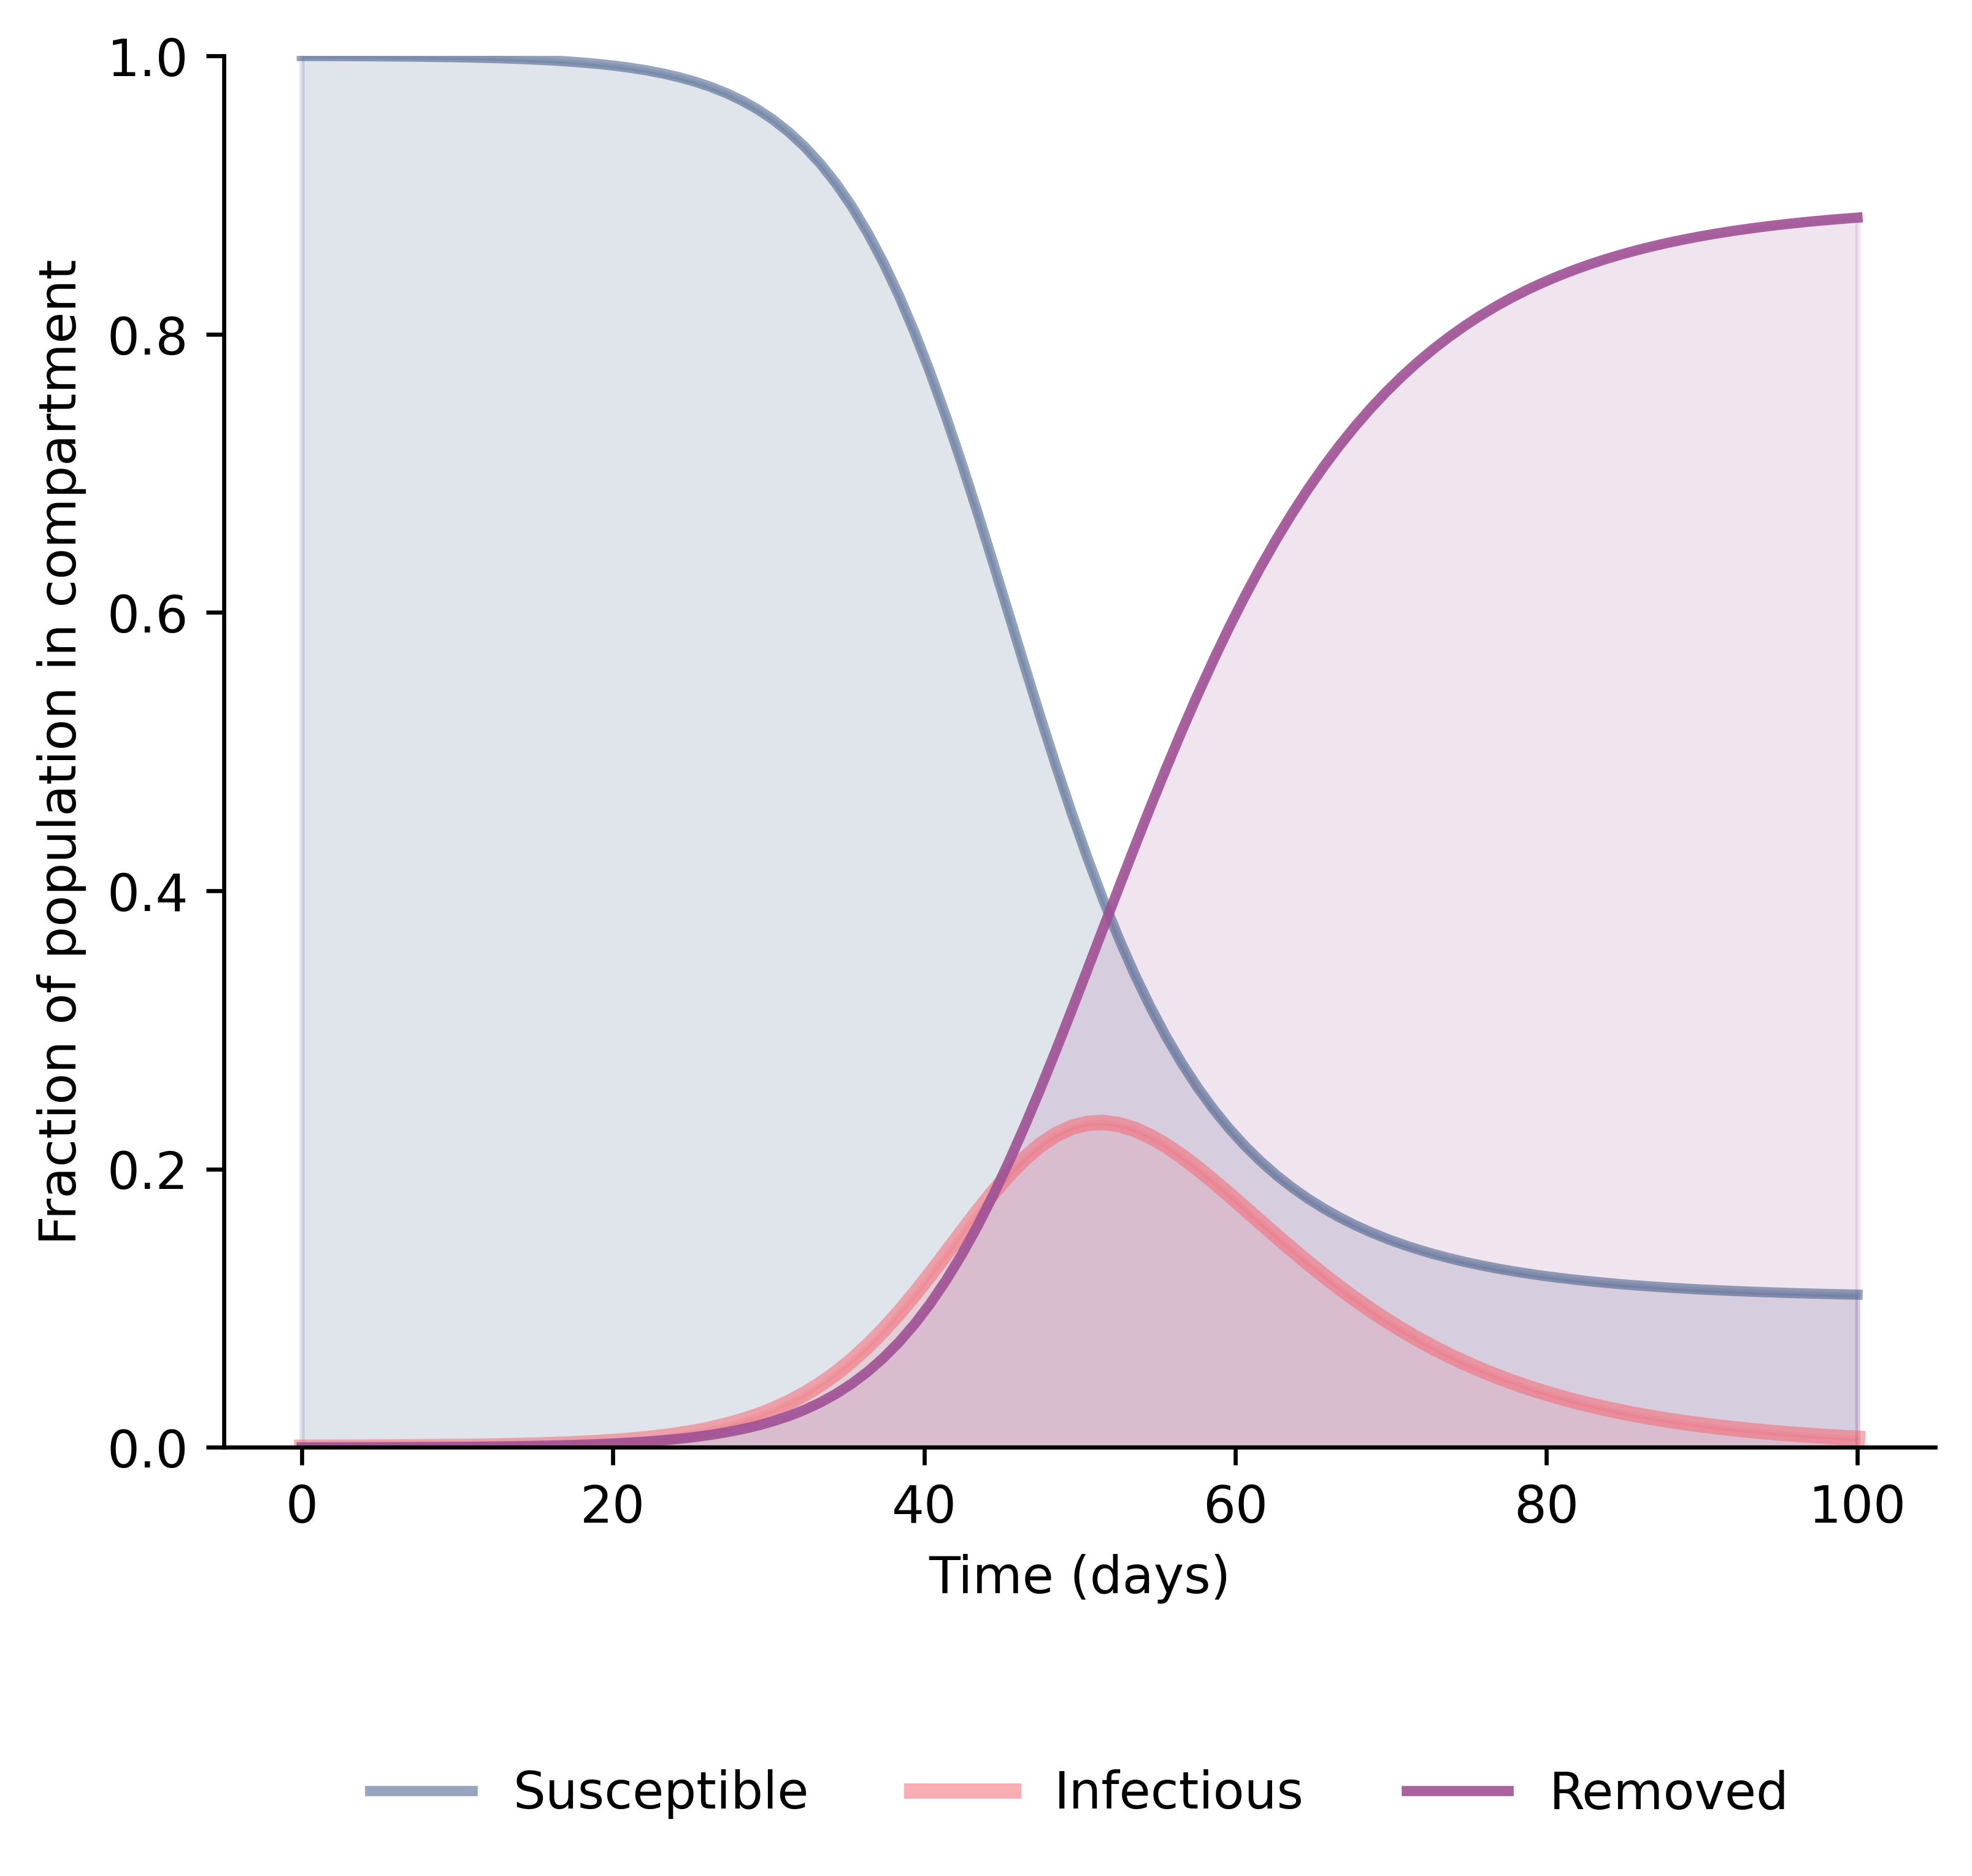

In [6]:
# We obtain each column by transposing then indexing (as Numpy indexes by default in rows)
S, I, R = res.T
fig = plt.figure(figsize=(6, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(t, I, color=COLORS["I"], alpha=0.5, lw=3, label="Infectious")
ax.plot(t, R, color=COLORS["R"], alpha=0.9, lw=2, label="Removed")

ax.fill_between(t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(t, 0, R, color=COLORS["R"], alpha=0.15)

ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

fig.subplots_adjust(bottom=0.25)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=3, frameon=False)

plt.savefig("sir_integral.pdf")
plt.show()

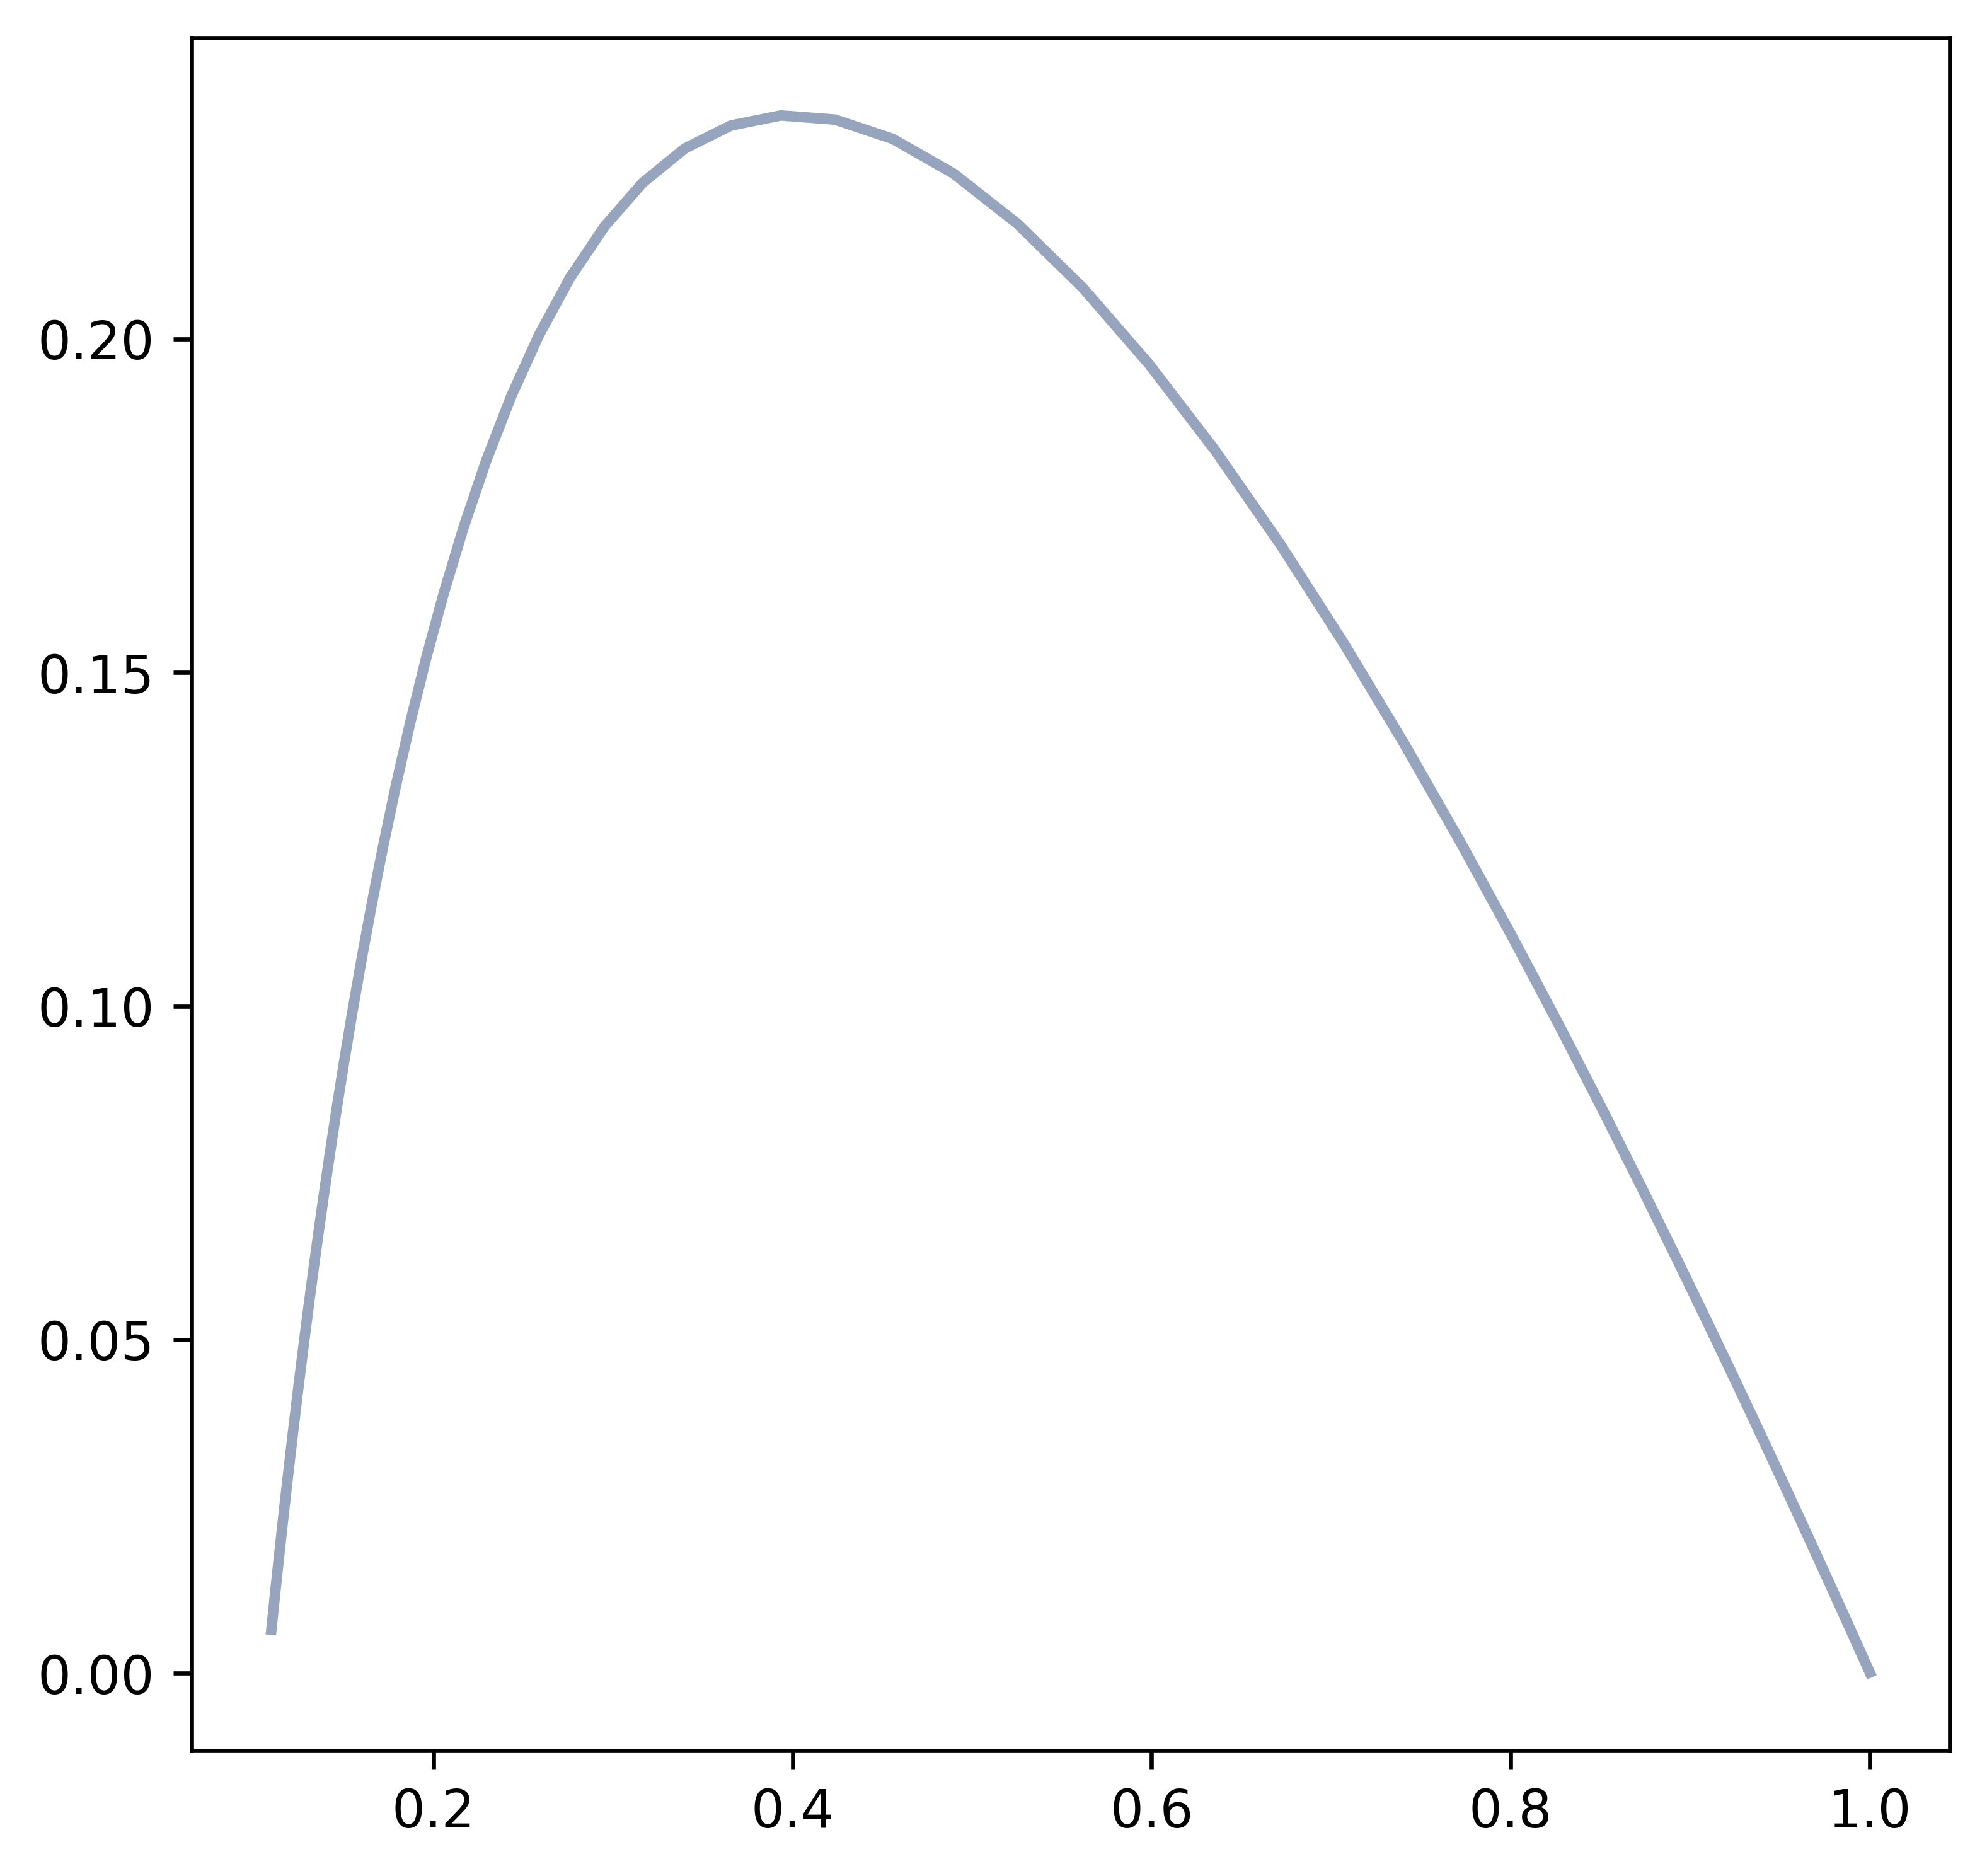

In [7]:
fig = plt.figure(facecolor="w", figsize=(6, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(S, I, color=COLORS["S"], alpha=0.5, lw=2)

In [8]:
def integrate_for_i0(*i0_arr):
    result = []
    
    for each in i0_arr: 
        res = odeint(func=deriv, y0=(1 - each, each, 0), t=t, args=(beta, gamma)).T
        result.append([res[0], res[1]])

    return result

In [9]:
s = integrate_for_i0(*np.linspace(1e-5, 1e-1, 10).tolist())

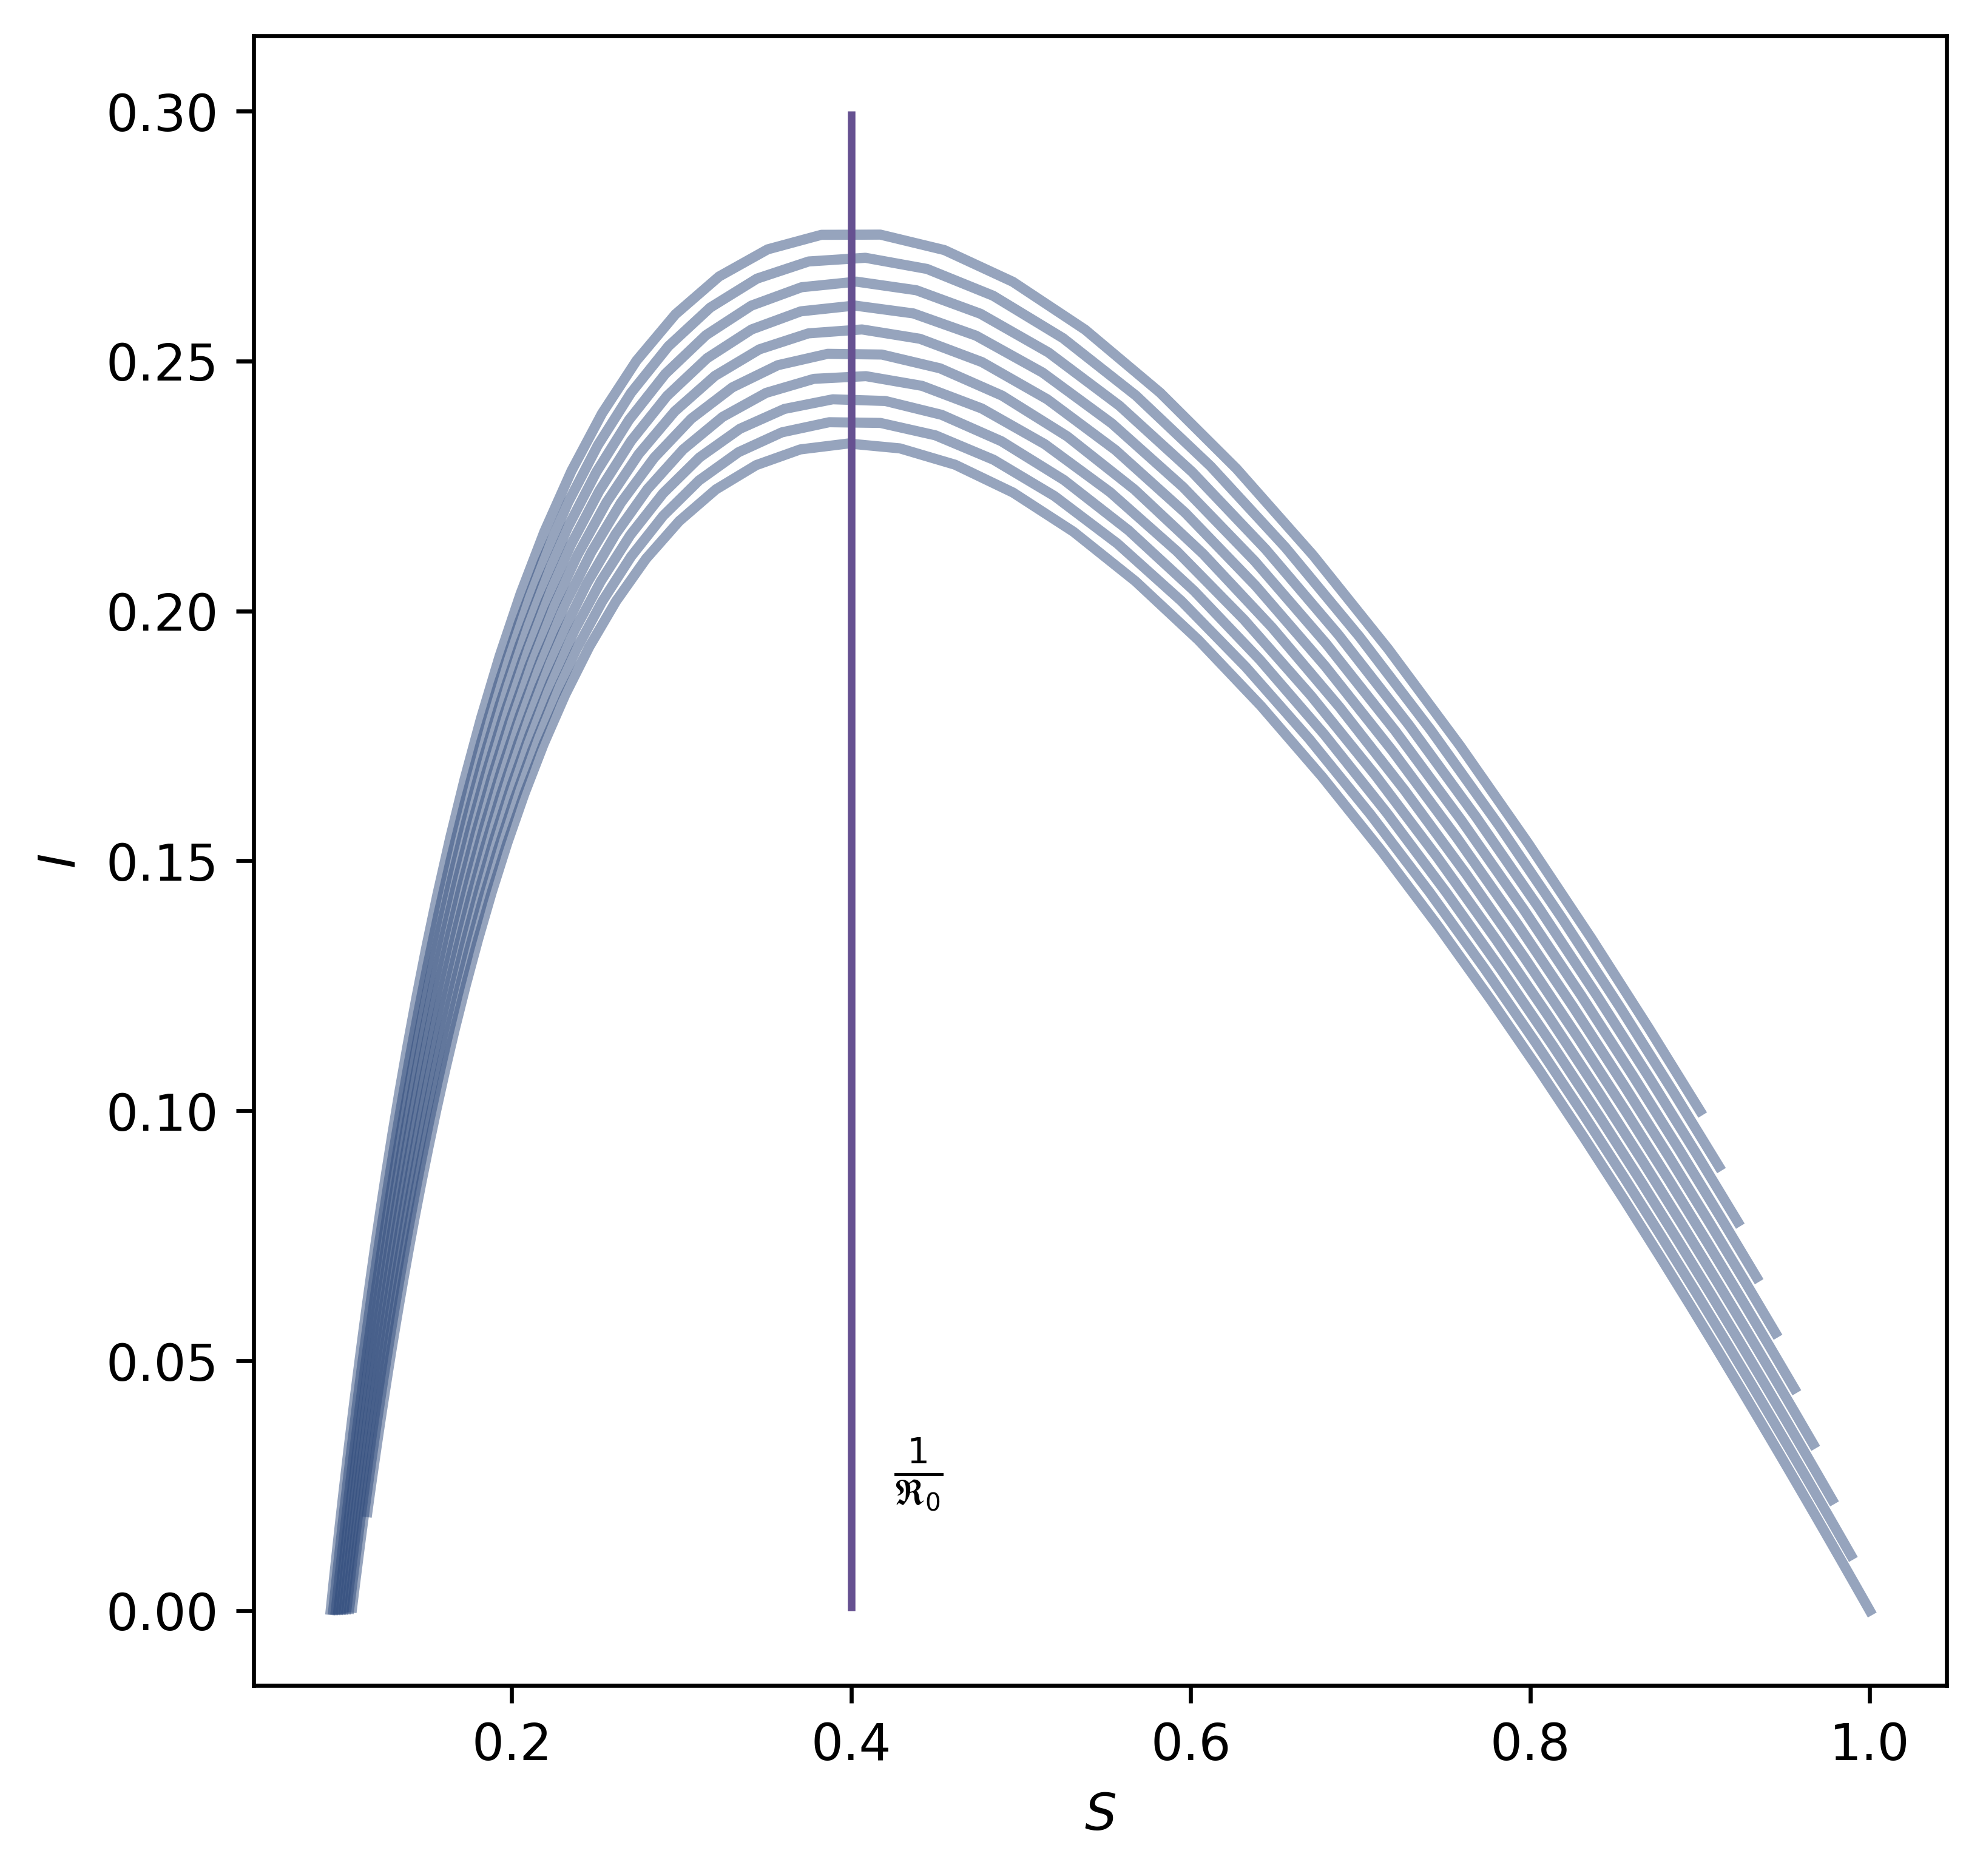

In [10]:
fig = plt.figure(facecolor="w", figsize=(6, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)
for each in s:
    ax.plot(each[0], each[1], color=COLORS["S"], alpha=0.5, lw=2)

ax.vlines(x=1/R0, ymin=0, ymax=0.3, color=COLORS["X"])
ax.annotate("$\\frac{1}{\\mathfrak{R}_0}$", xy = (0.425,0.025))
ax.set_ylabel("$I$")
ax.set_xlabel("$S$")

plt.savefig("characteristic_curves.pdf")

## Solving with `solve_ivp`

The `solve_ivp` API differs in a number of significant ways from the `odeint` API:

* `solve_ivp` function definitions of ODEs are ordered as `(t, y, *args)` rather than `(y, t, *args)` - i.e. the point of evaluation comes first
* `solve_ivp` does not require the integration interval to be specified as an iterable - the argument `t_span` is simply a tuple of minimum and maximum values

Equally, the result is returned in a rather different way:

* calling the result itself returns a verbose output
* calling `.t` on the result provides the points at which integration was performed
* calling `.y` provides the values - in this case, as a tuple of tuples that will not have to be transposed 

In [11]:
I_0 = 0.0001
S_0 = 1 - I_0
R_0 = 0

y_0 = (S_0, I_0, R_0)

R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma

In [12]:
def deriv(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [13]:
res = solve_ivp(fun=deriv, t_span = (0, 100), y0=y_0, args=(beta, gamma), max_step=1)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/2071377568.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


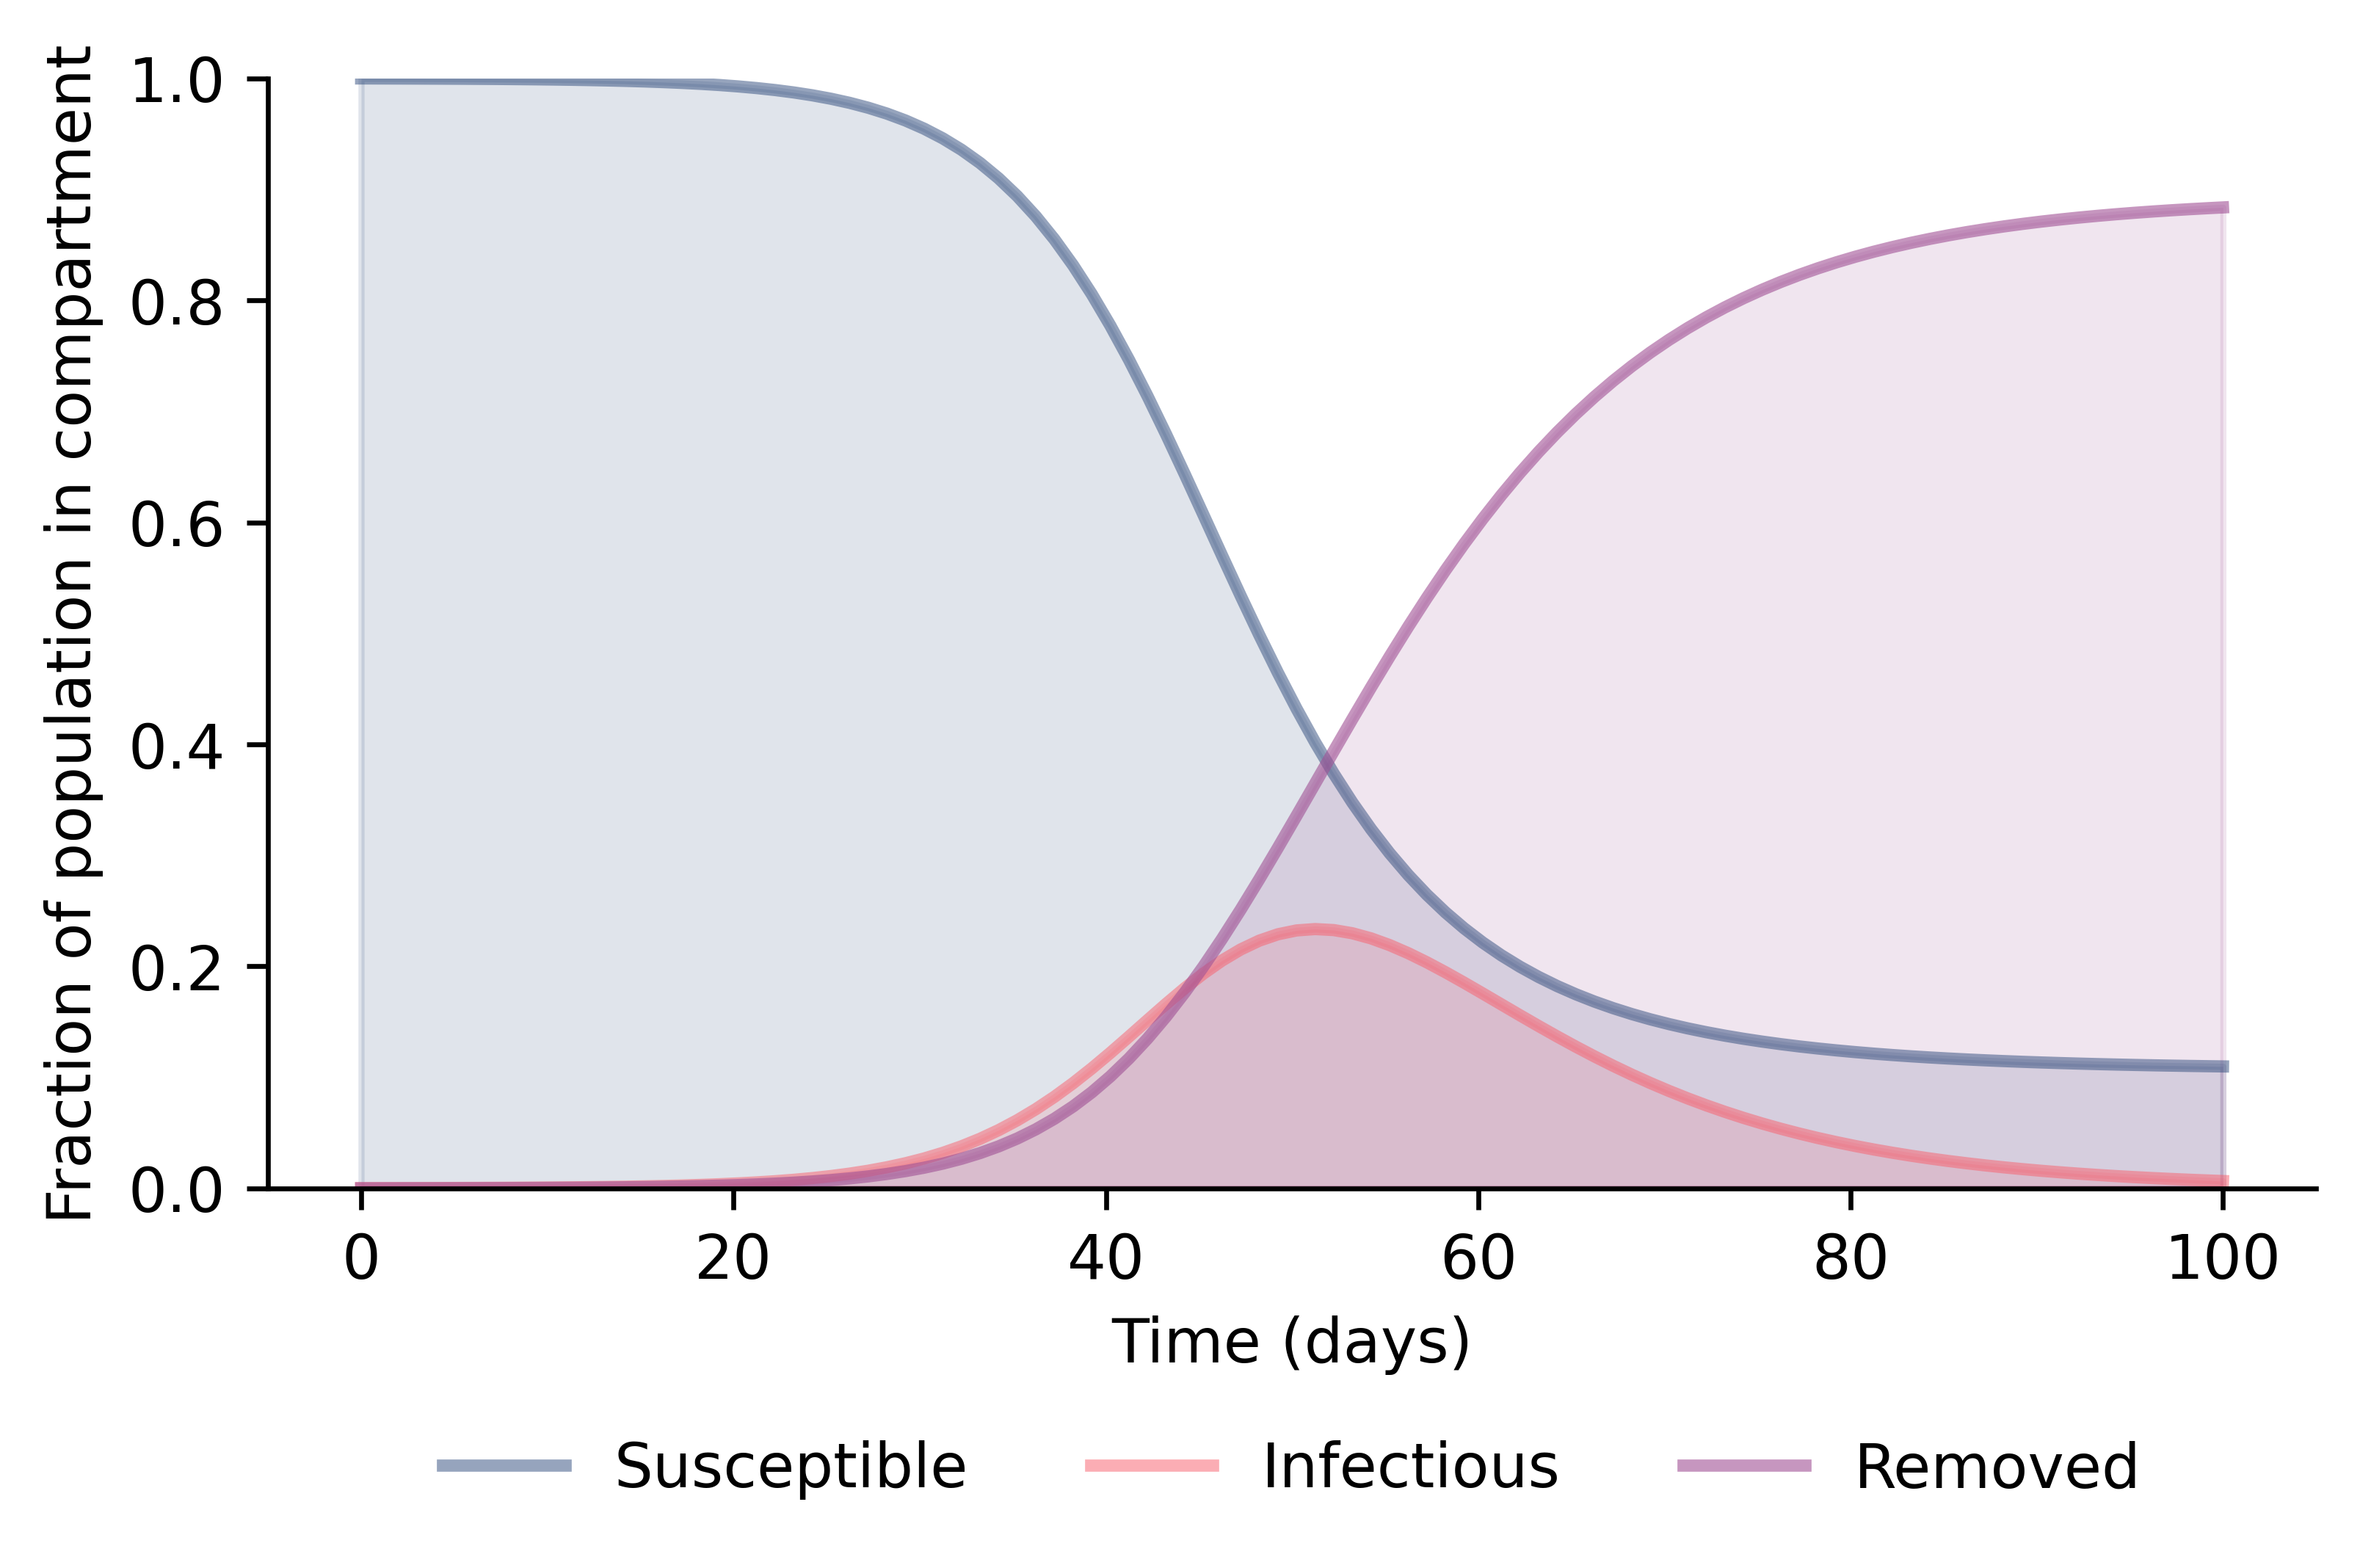

In [14]:
S, I, R = res.y

fig = plt.figure(facecolor="w", figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(res.t, R, color=COLORS["R"], alpha = 0.6, lw=2, label="Removed")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(res.t, 0, R, color=COLORS["R"], alpha=0.15)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.33), loc="lower center", ncol=3, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("sir_integral.pdf")
plt.show()

# Epidemic curves as a function of $\tau$ and $R_0$

In [15]:
R_0_range = [2, 3, 4, 5, 7.5, 10]
tau_range = [7, 10, 14, 21]

epicurves = {}

for i in R_0_range:
    epicurves[i] = {}
    for j in tau_range:
        epicurves[i][j] = []

In [16]:
for i in R_0_range:
    for j in tau_range:
        gamma = 1/j
        beta = i * gamma
        res = solve_ivp(fun=deriv, t_span = (0, 100), y0=y_0, args=(beta, gamma), max_step=1)
        epicurves[i][j] = [t, res.y[1], res.y[0], res.y[2]]


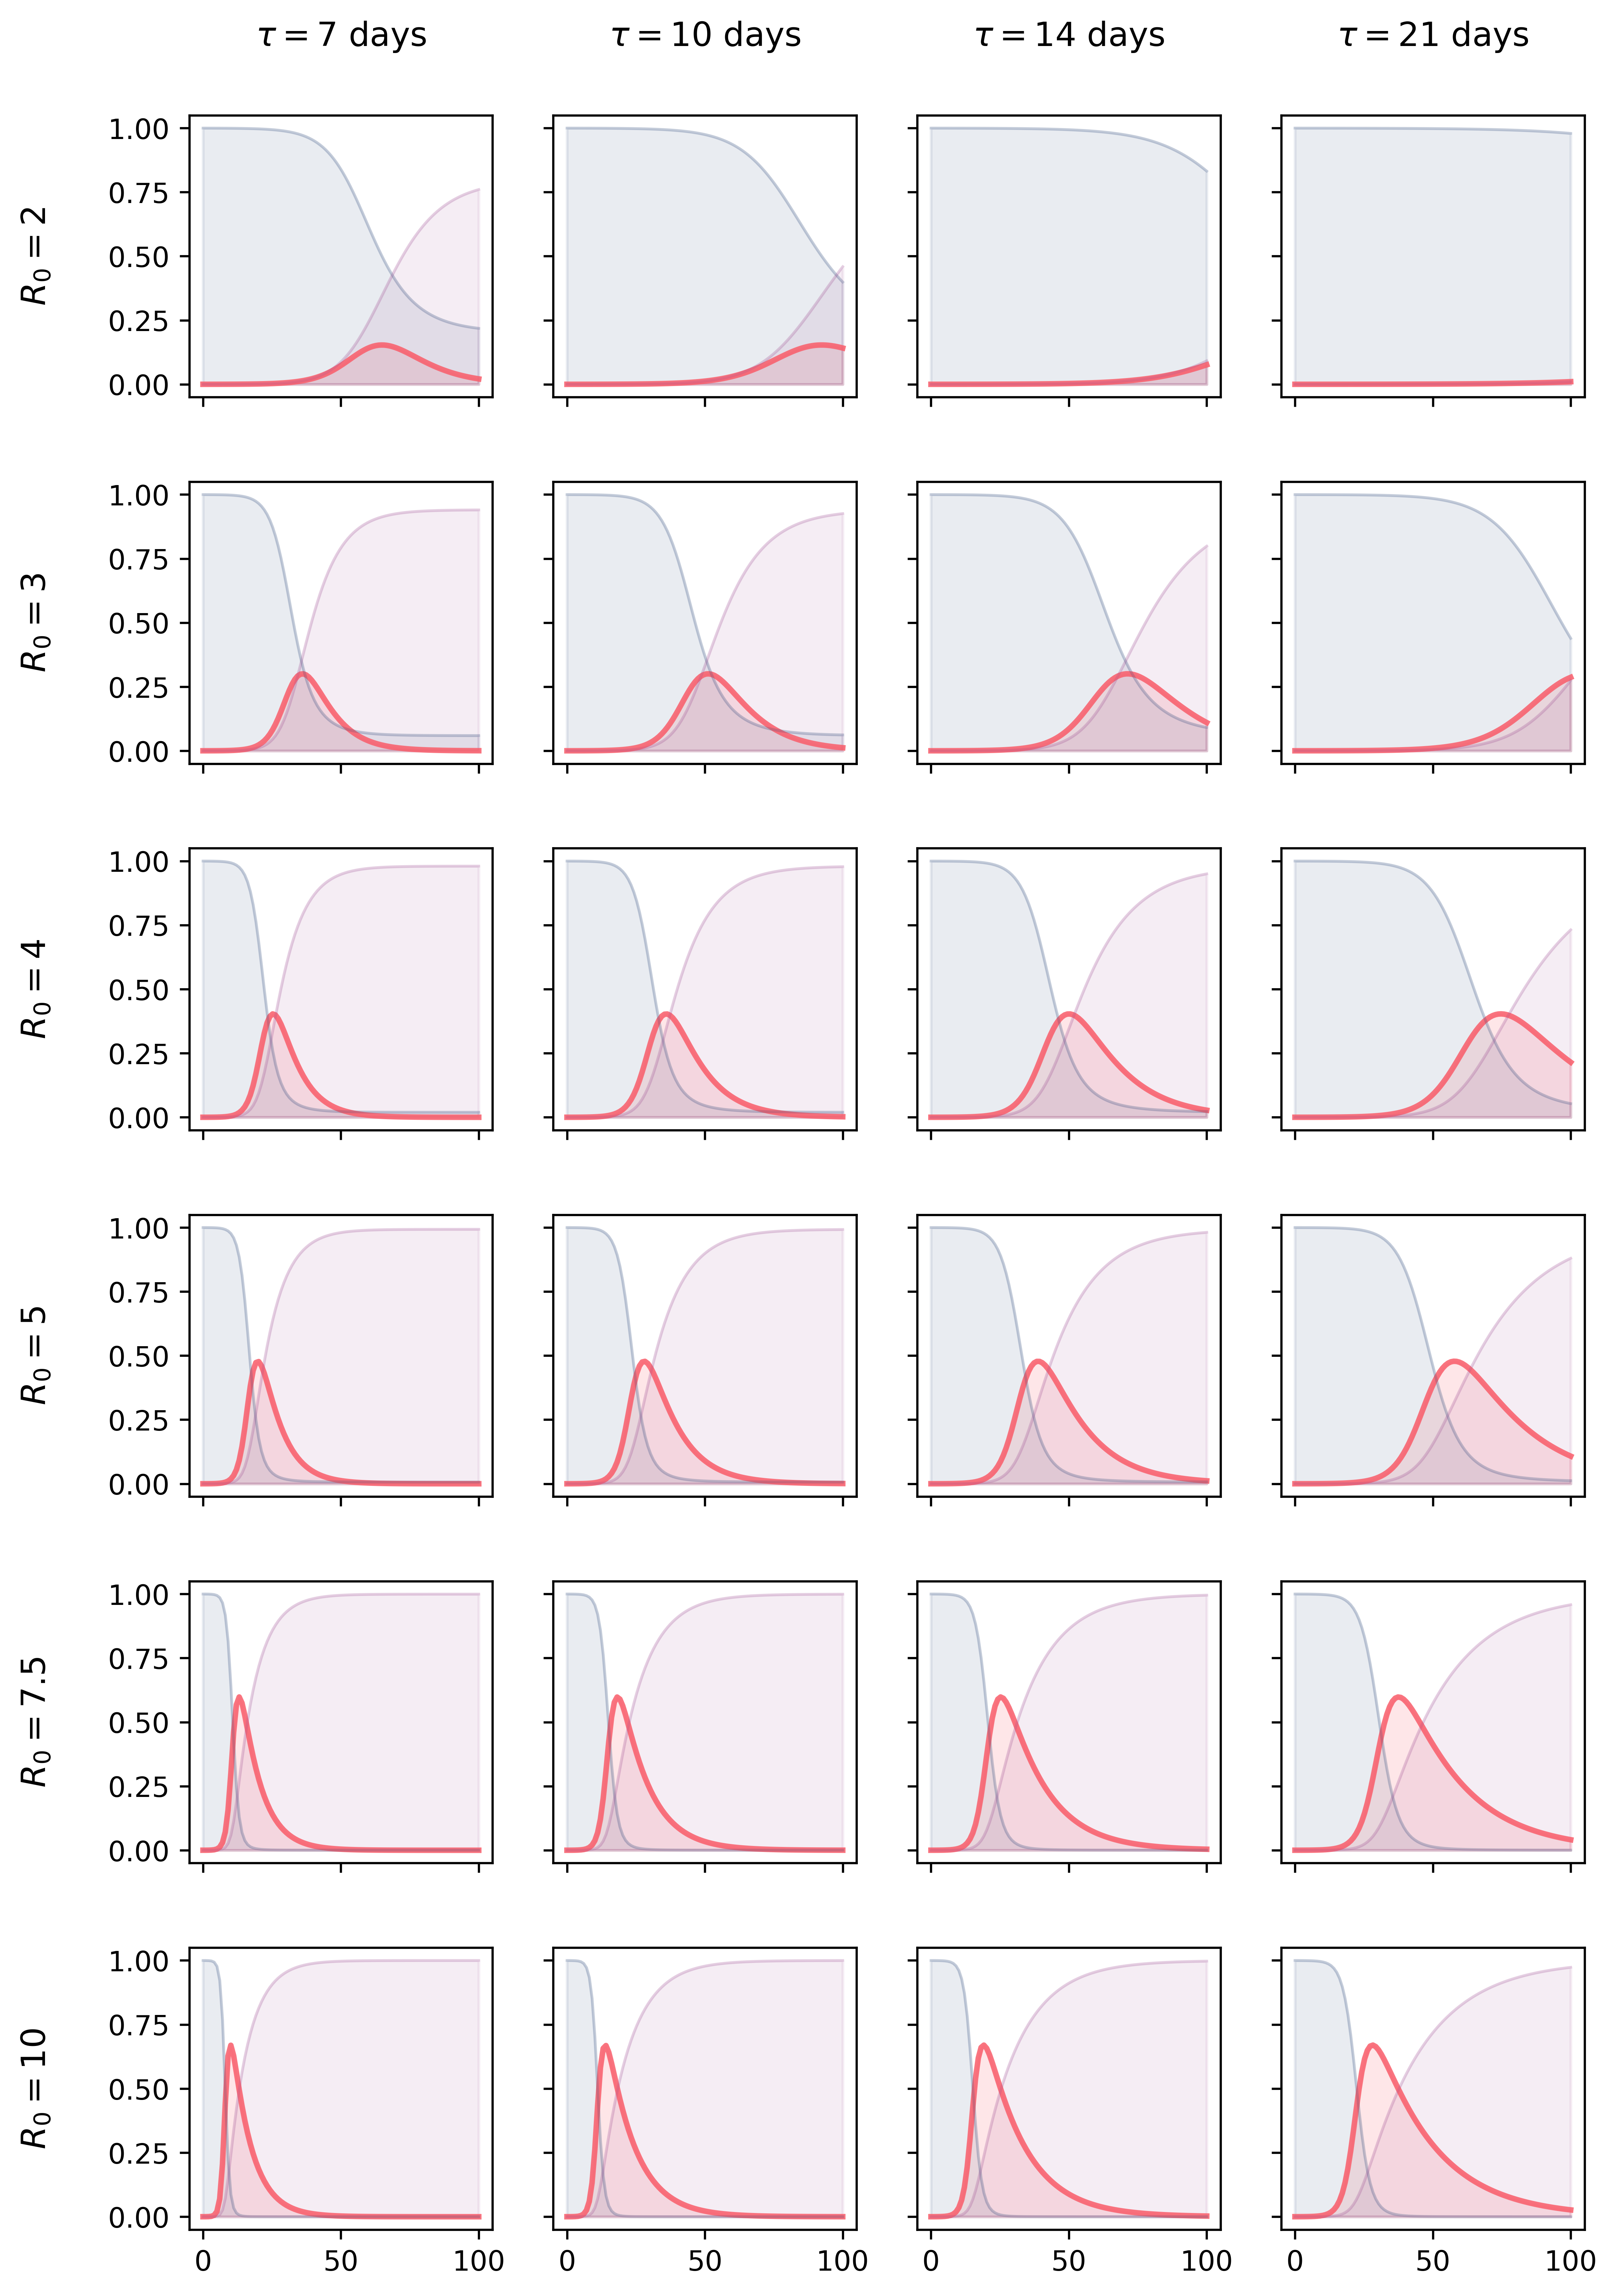

In [17]:
fig, axs = plt.subplots(len(R_0_range), len(tau_range), sharex=True, sharey=True, figsize=(1.5*len(R_0_range), 3.5*len(tau_range)), dpi=600)

for iidx, ival in enumerate(R_0_range):
    for jidx, jval in enumerate(tau_range):
        axs[iidx][jidx].plot(epicurves[ival][jval][0], epicurves[ival][jval][1][:100], color=COLORS["I"], alpha=0.85, lw=2)
        axs[iidx][jidx].fill_between(epicurves[ival][jval][0], 0, epicurves[ival][jval][1][:100], color=COLORS["I"], alpha=0.15)
        axs[iidx][jidx].plot(epicurves[ival][jval][0], epicurves[ival][jval][2][:100], color=COLORS["S"], alpha=0.2, lw=1)
        axs[iidx][jidx].fill_between(epicurves[ival][jval][0], 0, epicurves[ival][jval][2][:100], color=COLORS["S"], alpha=0.1)
        axs[iidx][jidx].plot(epicurves[ival][jval][0], epicurves[ival][jval][3][:100], color=COLORS["R"], alpha=0.2, lw=1)
        axs[iidx][jidx].fill_between(epicurves[ival][jval][0], 0, epicurves[ival][jval][3][:100], color=COLORS["R"], alpha=0.1)

cols = [r"$\tau = {} $ days".format(col) for col in tau_range]
rows = [r"$R_0 = {}$".format(row) for row in R_0_range]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, pad=25)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size="large", labelpad=20)

fig.subplots_adjust(hspace=0.3)

plt.savefig("tau_r0_matrix.pdf")

# SIRD model

The SIRD model is governed by the following system of ODEs:

\begin{equation}
        \frac{dS}{dt} =    - \beta S I
\end{equation}

\begin{equation}
        \frac{dI}{dt} =    \beta S I - \gamma I
\end{equation}

\begin{equation}
        \frac{dR}{dt} =    \gamma (1 - \mu) I
\end{equation}

\begin{equation}
        \frac{dD}{dt} =    \gamma \mu I
\end{equation}

We assume $R_0 = 2.5$ and $\tau = 8$.

From this follows that $\gamma = \tau^{-1}$ and $\beta = R_0 \gamma$.

We furthermore assume a mortality fraction (Case Fatality Ratio) of 20%, i.e. $\mu = 0.2$.

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/4126088050.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


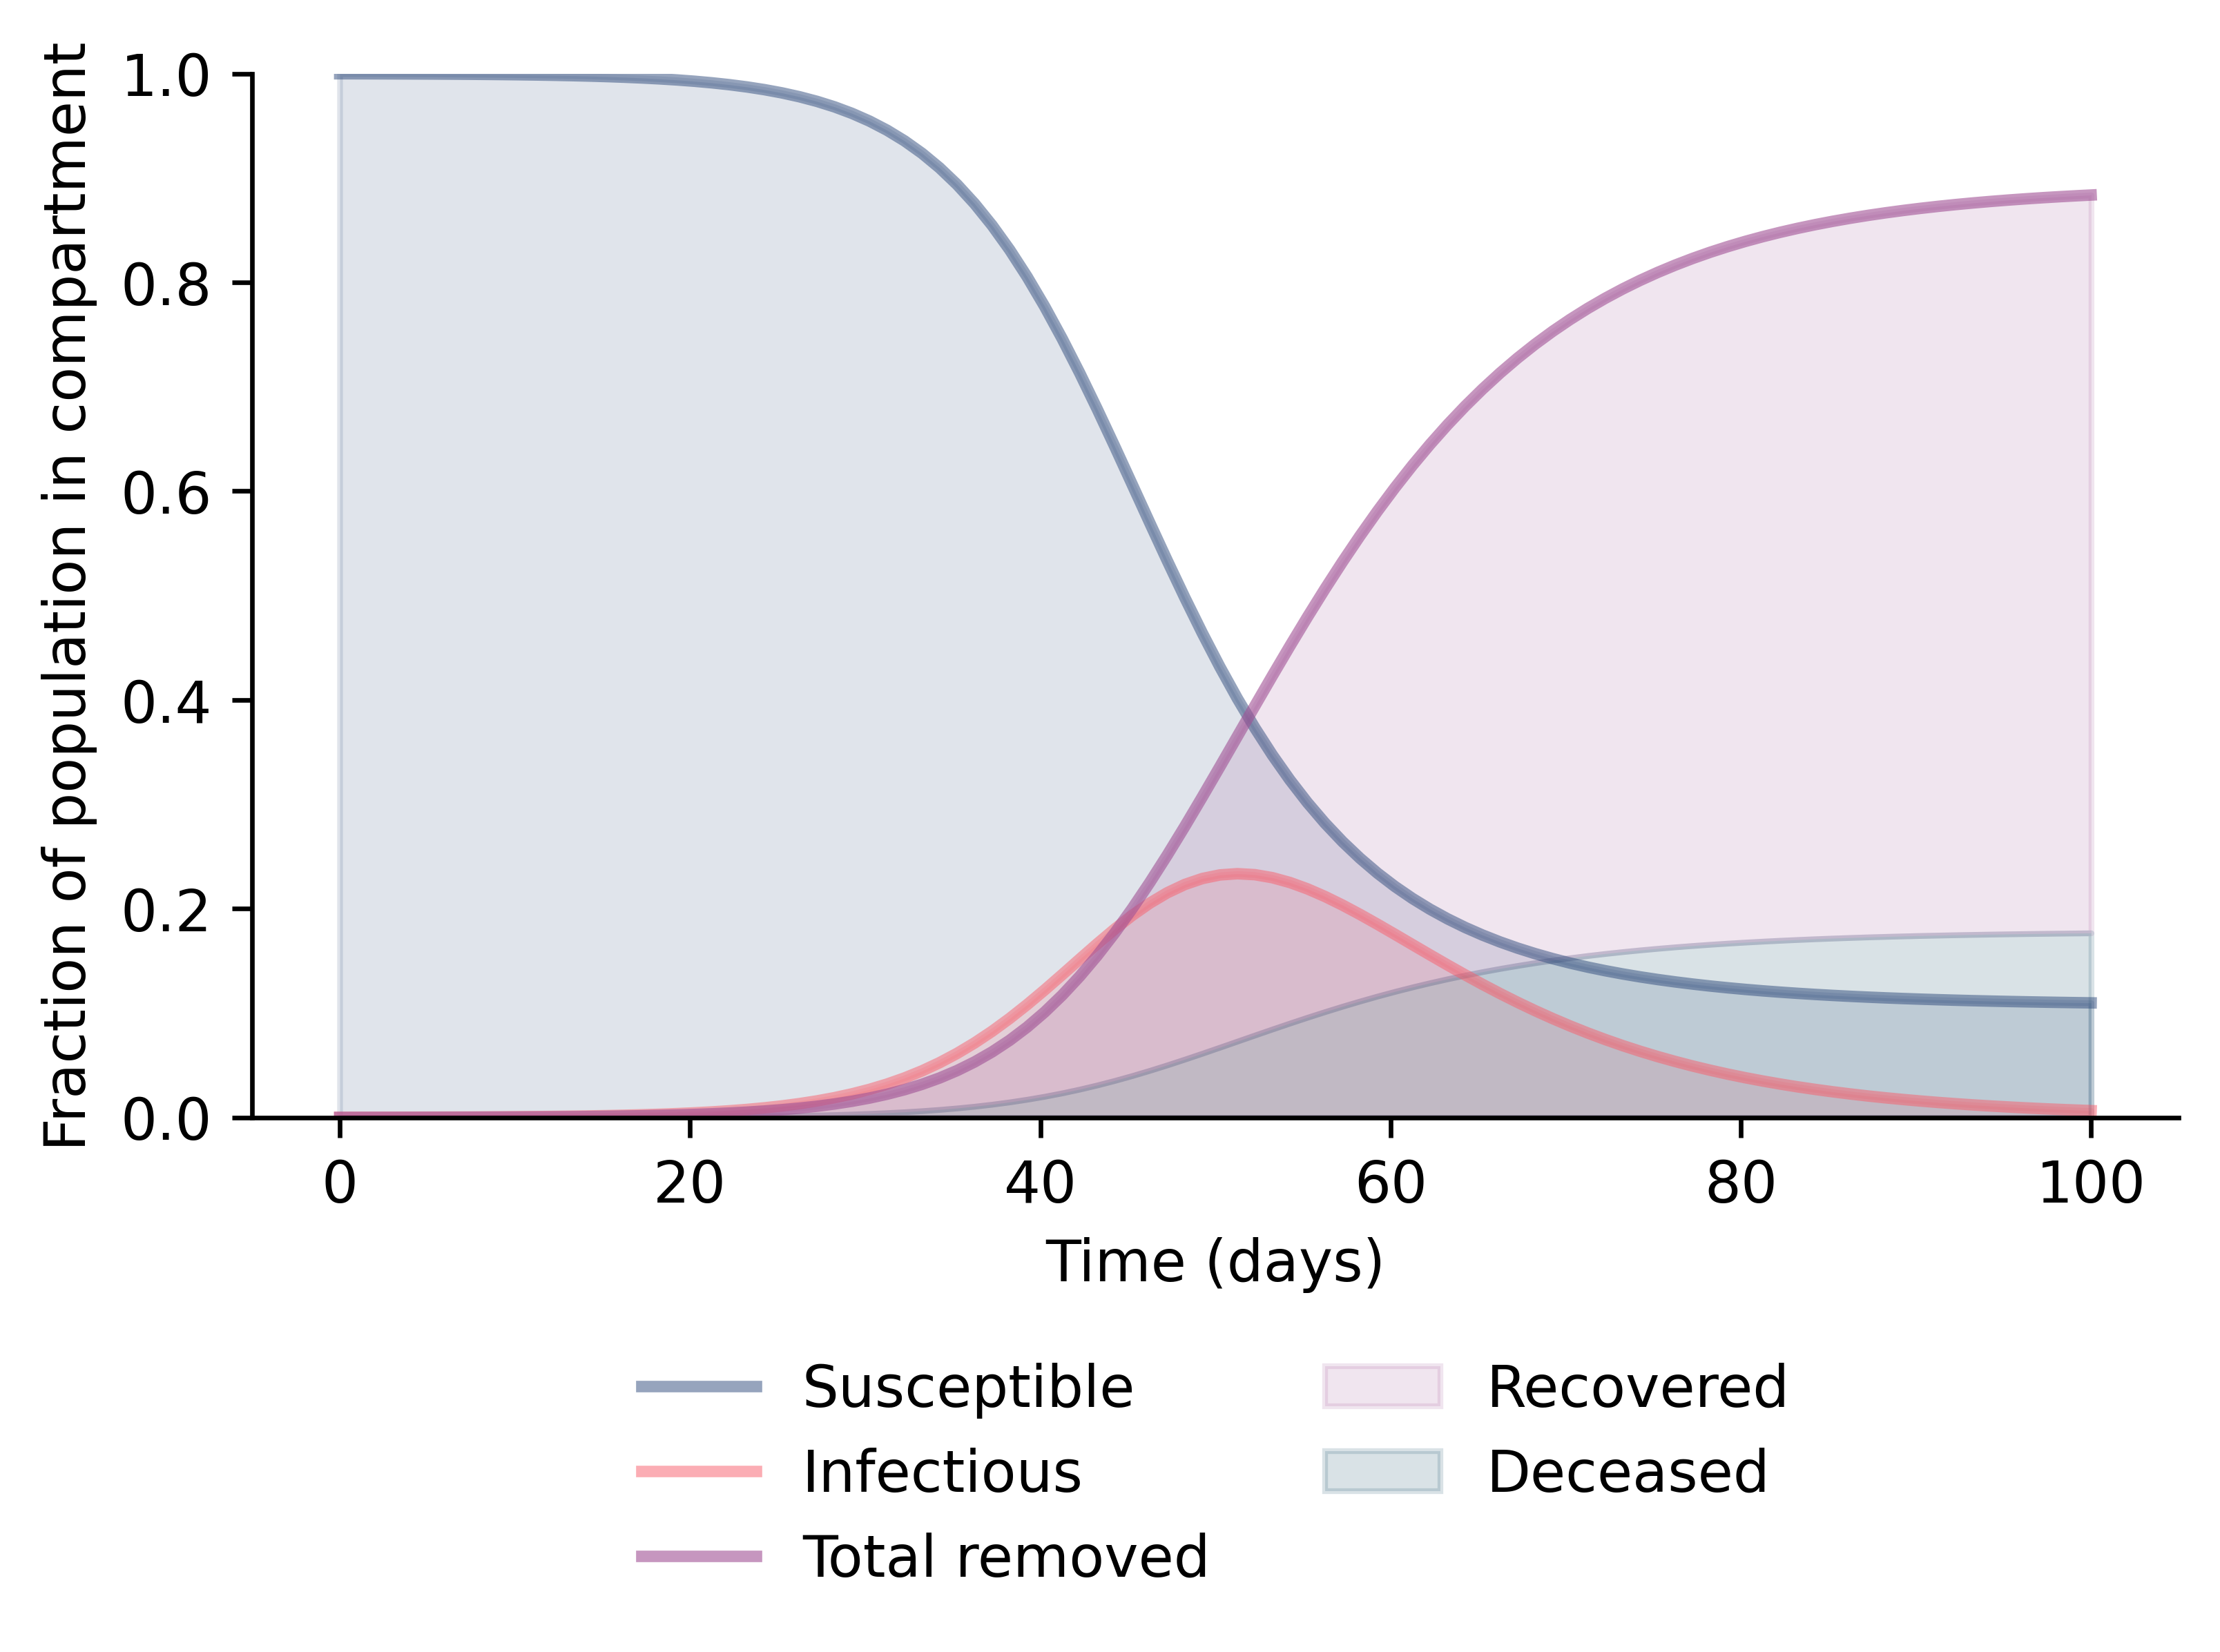

In [18]:
def deriv(t, y, beta, gamma, mu):
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return dSdt, dIdt, dRdt, dDdt

I_0 = 0.0001
S_0 = 1 - I_0
R_0, D_0 = 0, 0

y_0 = (S_0, I_0, R_0, D_0)

R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma
mu = 0.2
res = solve_ivp(fun=deriv, t_span = (0, 100), y0=y_0, args=(beta, gamma, mu), max_step=1)
S, I, R, D = res.y

fig = plt.figure(facecolor="w", figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(res.t, R + D, color=COLORS["R"], alpha = 0.6, lw=2, label="Total removed")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(res.t, D, R + D, color=COLORS["R"], alpha=0.15, label="Recovered")
ax.fill_between(res.t, 0, D, color=COLORS["D"], alpha=0.15, label="Deceased")

ax.set_xlabel("Time (days)")
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.5), loc="lower center", ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("sird_integral.pdf")
plt.show()

# SI model

\begin{equation}
    \frac{dS}{dt} = - \beta S I + \gamma I
\end{equation}

\begin{equation}
    \frac{dI}{dt} = \beta S I - \gamma I
\end{equation}

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/1519567869.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


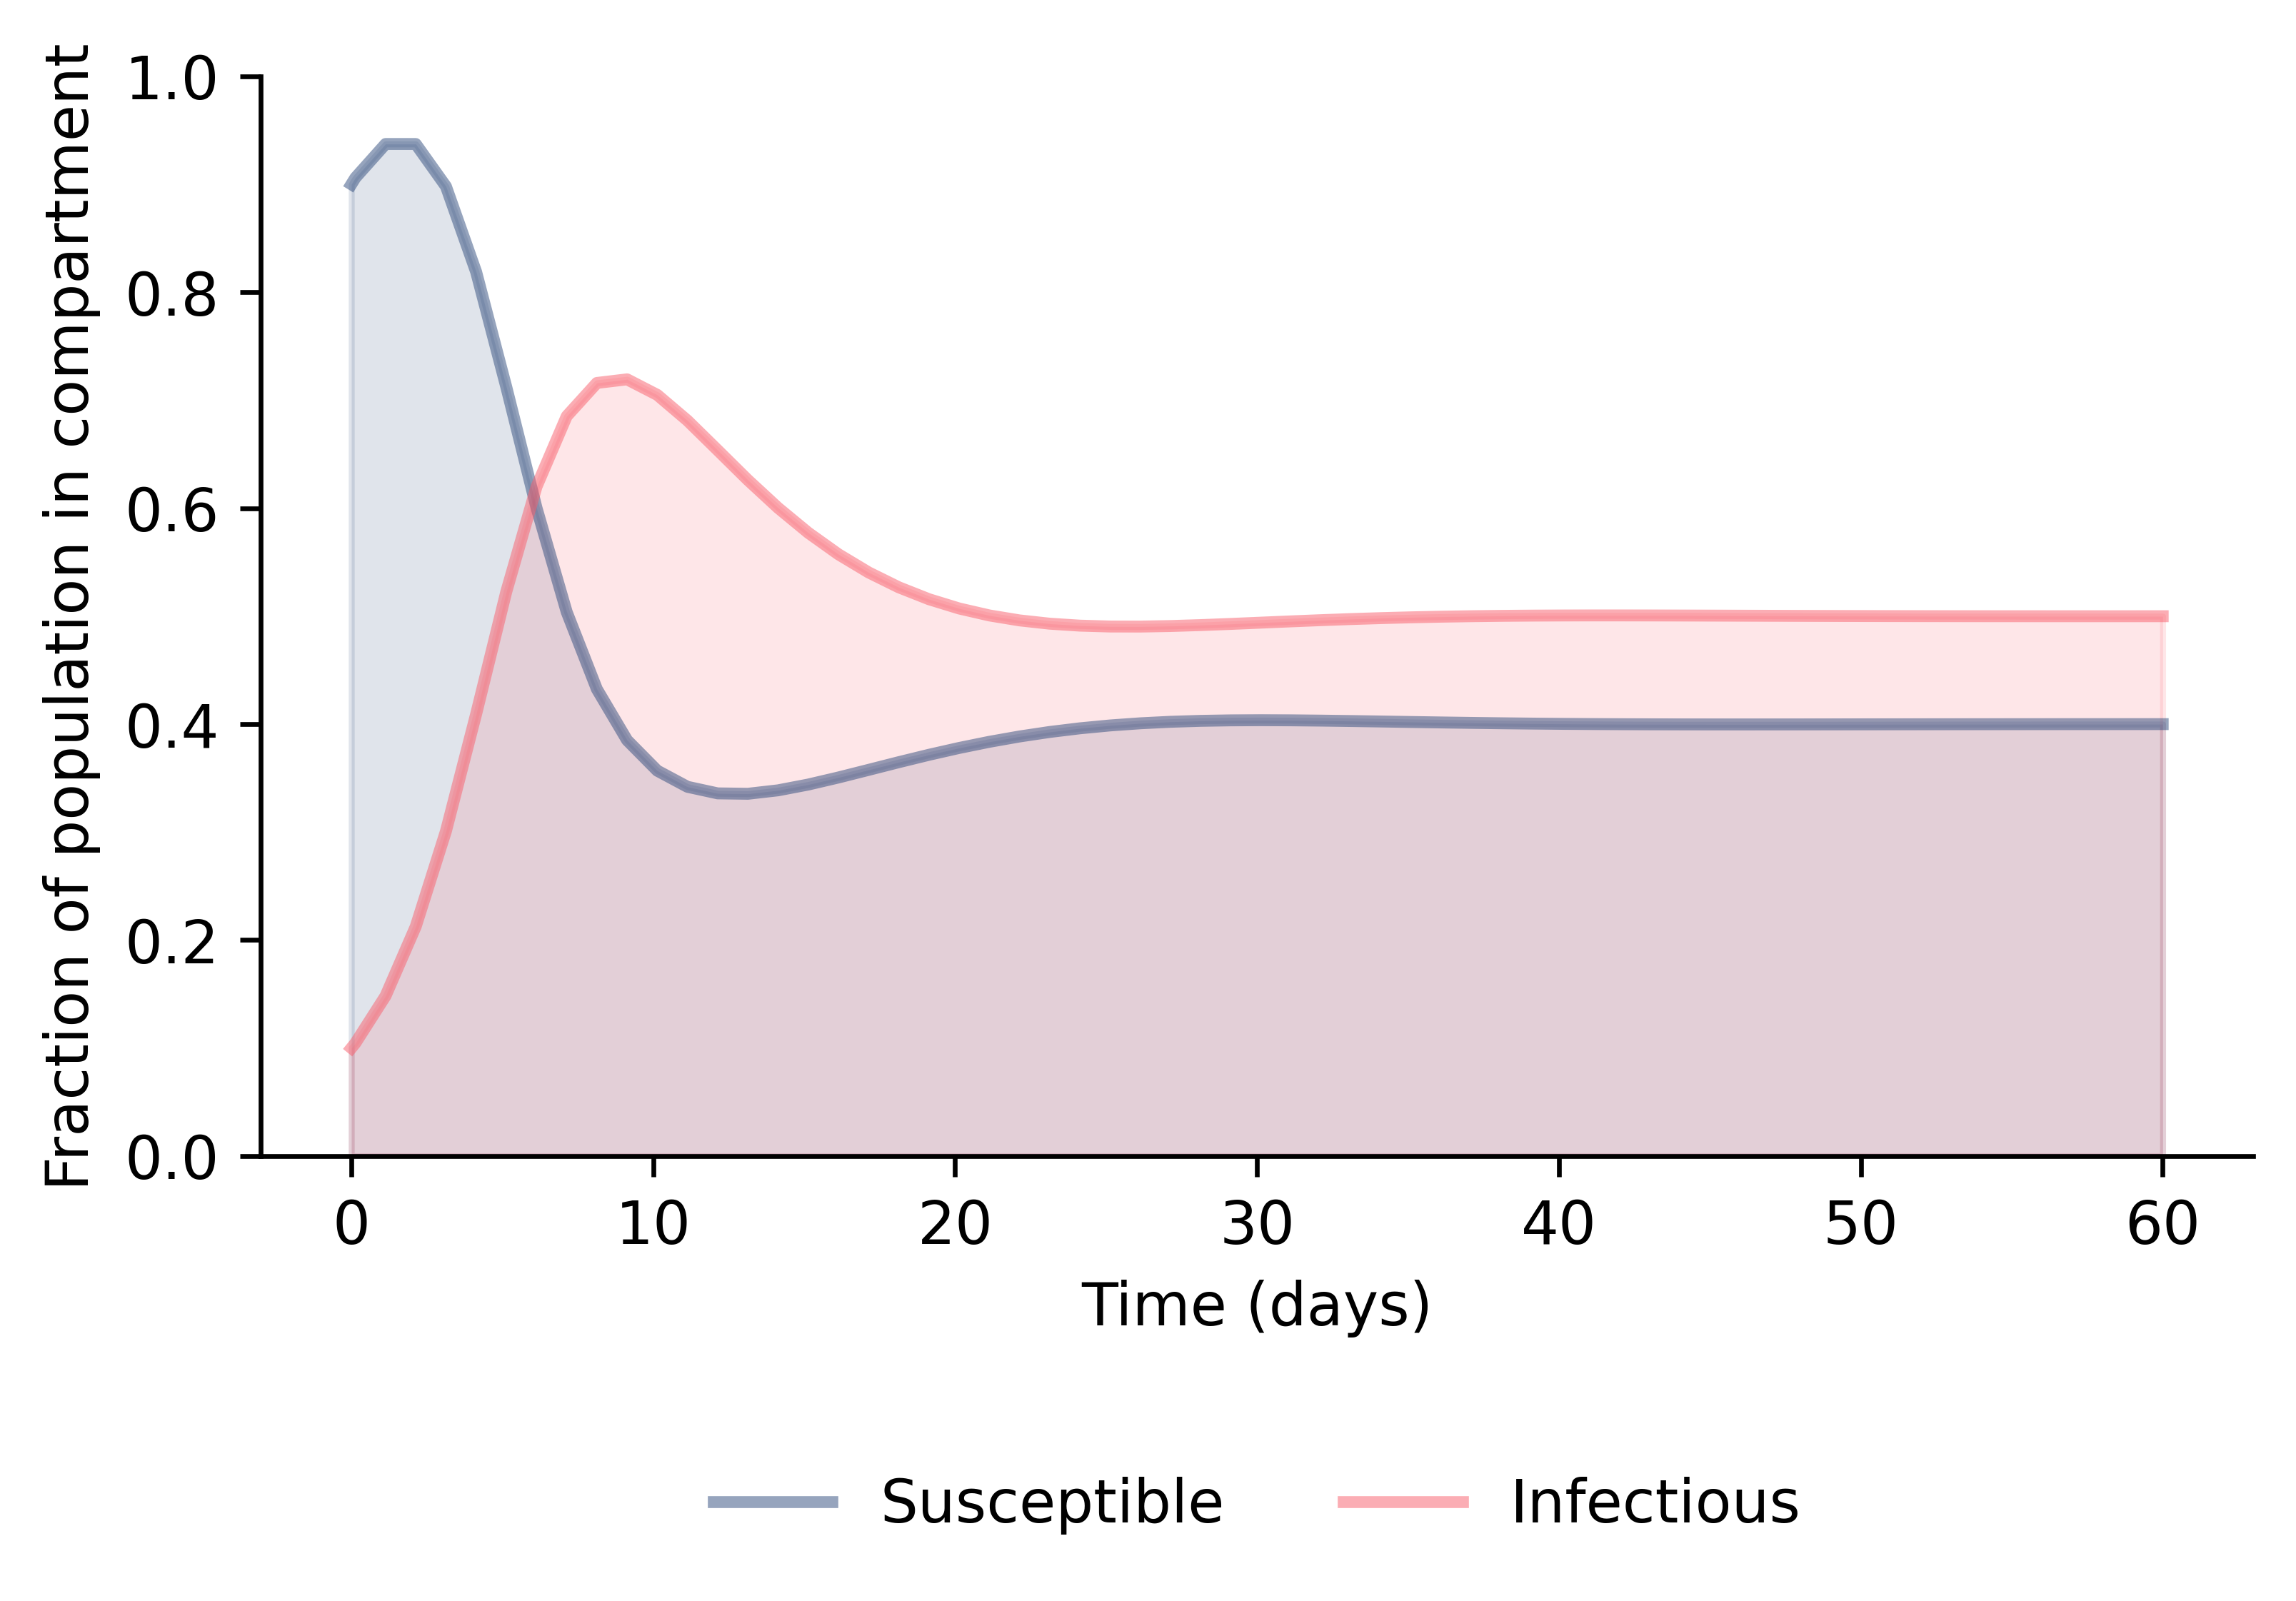

In [19]:
I_0 = 1e-1
S_0 = 1 - I_0

y_0 = (S_0, I_0)
R0 = 4
tau = 6
gamma = 1/tau
beta = R0 * gamma
mu = 0.1

def deriv(t, y, beta, gamma):
    S, I = y

    dSdt = mu - beta * S * I + gamma * I - mu * I
    dIdt = beta * S * I - gamma * I - mu * I

    return dSdt, dIdt

res = solve_ivp(fun=deriv, t_span = (0, 60), y0=y_0, args=(beta, gamma), max_step=1)

S, I = res.y

fig = plt.figure(facecolor="w", figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.4), loc="lower center", ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("si_integral.pdf")
plt.show()

# Waning immunity (SIRS)

\begin{equation}
    \frac{dS}{dt} =    - \beta S I + \omega R
\end{equation}

\begin{equation}
    \frac{dI}{dt} =    \beta S I - \gamma I
\end{equation}

\begin{equation}
    \frac{dR}{dt} =    \gamma I - \omega R
\end{equation}

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/1190986796.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


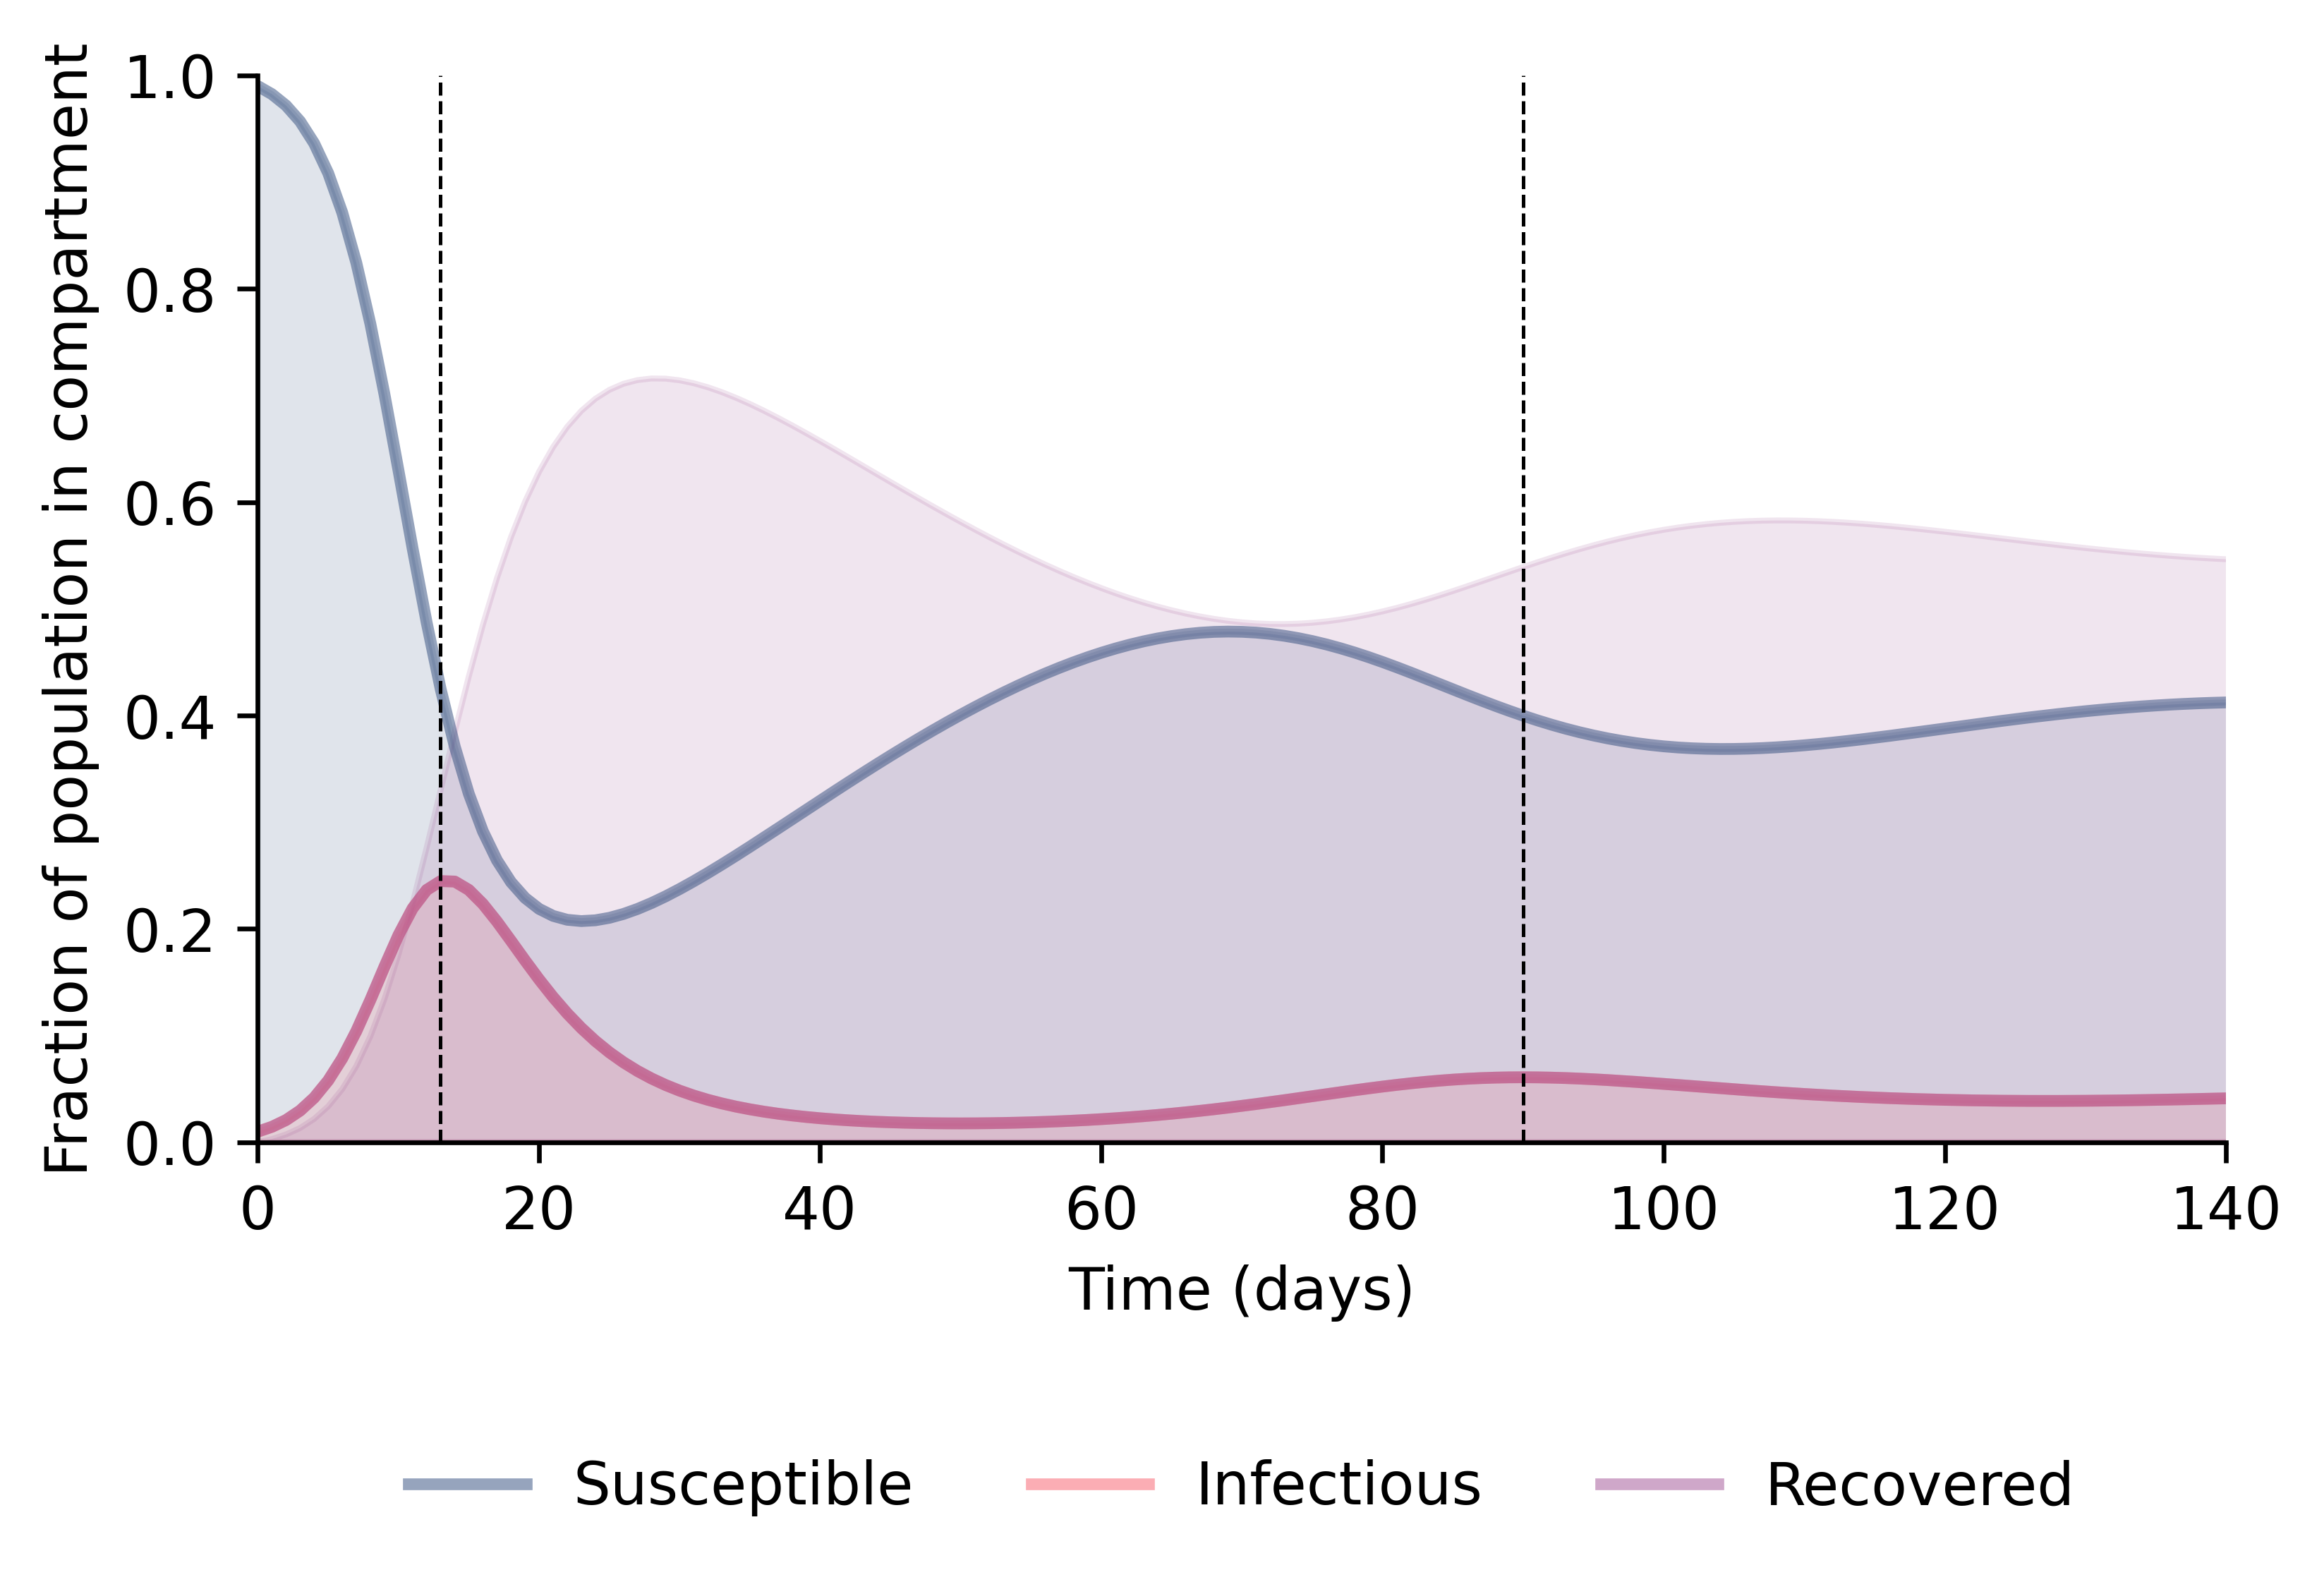

In [20]:
I_0 = 1e-2
S_0 = 1 - I_0
R_0 = 0

y_0 = (S_0, I_0, R_0)
R0 = 2.5
tau = 4
gamma = 1/tau
tau_R = 50
omega = 1/tau_R
beta = R0 * gamma
def deriv(t, y, beta, gamma, omega):
    S, I, R = y

    dSdt = - beta * S * I + omega * R
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I - omega * R

    return dSdt, dIdt, dRdt

res = solve_ivp(fun=deriv, t_span = (0, 5000), y0=y_0, args=(beta, gamma, omega), max_step=1)

S, I, R = res.y

fig = plt.figure(facecolor="w", figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(res.t, I, color=COLORS["R"], alpha=0.5, lw=2, label="Recovered")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(res.t, 0, R, color=COLORS["R"], alpha=0.15)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 140)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.vlines([13, 90], ymin=0, ymax=1, linestyles="dashed", lw=0.6, color="k")

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.4), loc="lower center", ncol=3, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("sirs_integral.pdf")
plt.show()

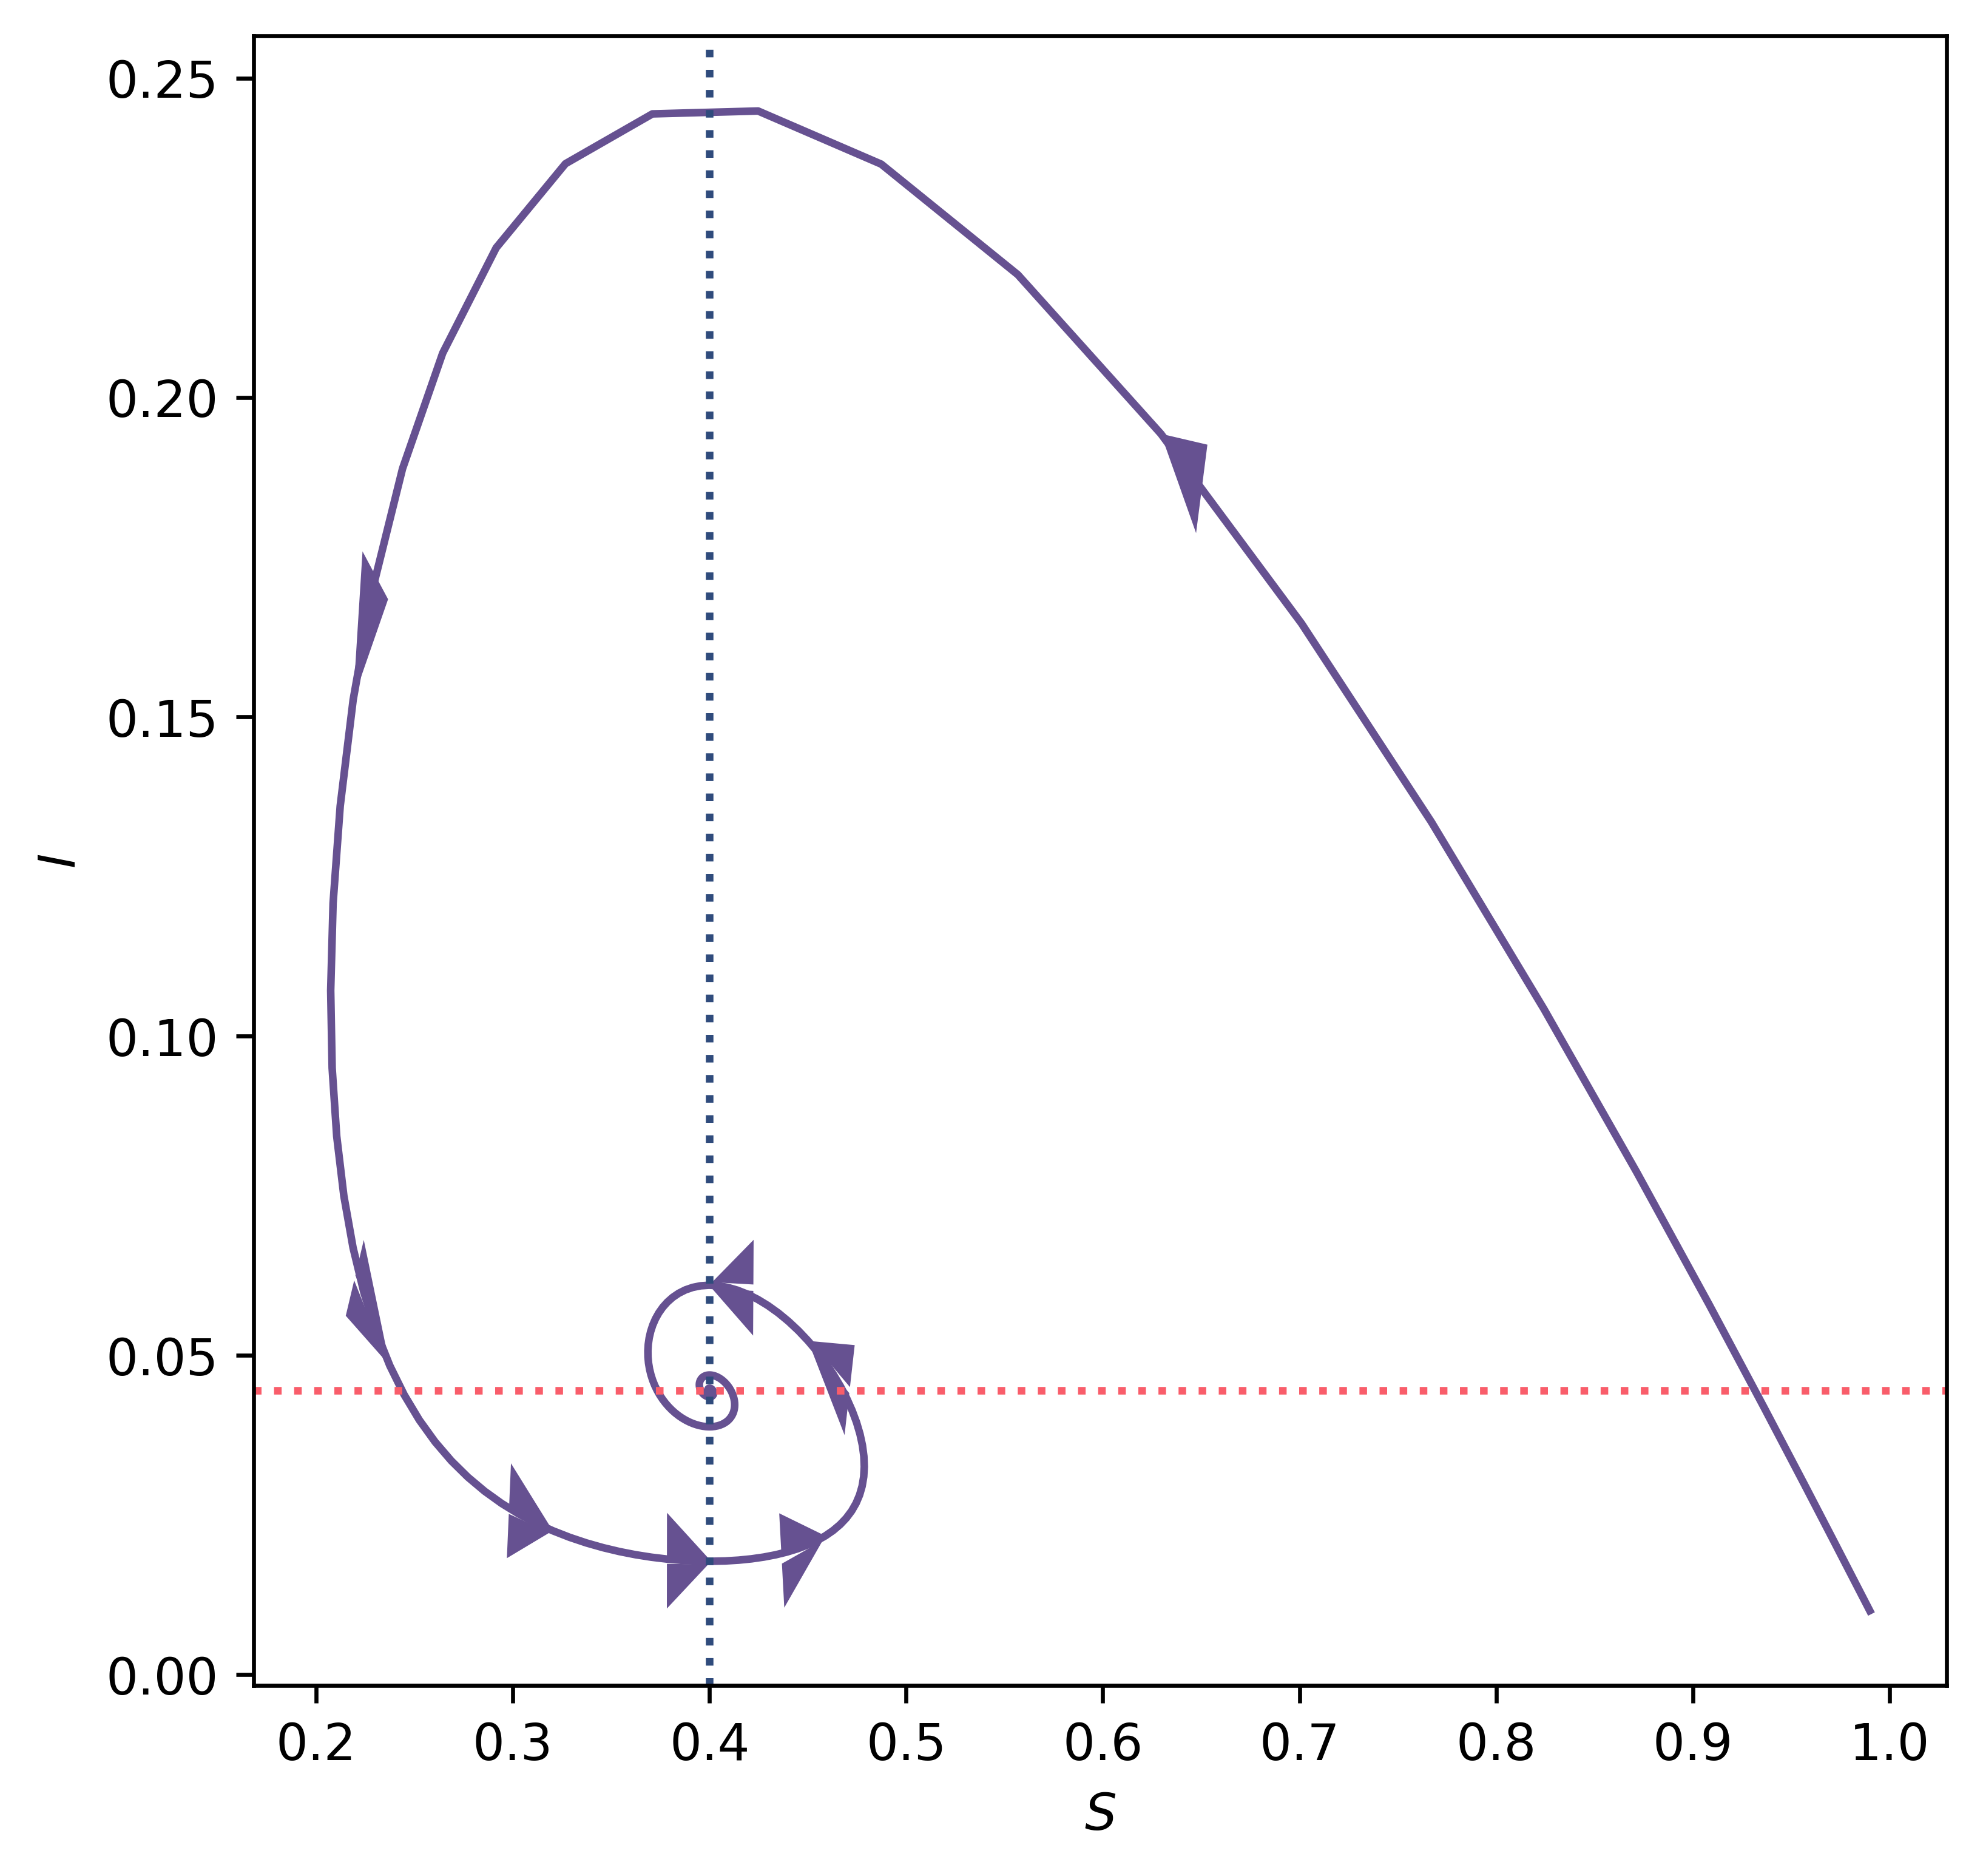

In [21]:
fig = plt.figure(facecolor="w", figsize=(6, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(S, I, color=COLORS["X"])
ax.set_ylabel("$I$")
ax.set_xlabel("$S$")

ax.axhline(y=I[-1], color=COLORS["I"], linestyle=":")
ax.axvline(x=S[-1], color=COLORS["S"], linestyle=":")

arrow_density: int = 6

for i in range(10, 100, 10):
    if np.sqrt((S[i + 1] - S[i])**2 + (I[i + 1] - I[i])**2) > 0.003:
        ax.arrow(x=S[i], y=I[i],
                 dx=S[i + 1] - S[i], dy=I[i + 1] - I[i],
                 shape="full",
                 lw=0,
                 length_includes_head=True,
                 head_width=.015,
                 color=COLORS["X"])

plt.savefig("sirs_phase_portrait.pdf")
plt.show()

# SEIR

\begin{equation}
    \frac{dS}{dt} = - \beta S I
\end{equation}

\begin{equation}
    \frac{dE}{dt} = \beta S I - \sigma E
\end{equation}

\begin{equation}
    \frac{dI}{dt} = \sigma E - \gamma I
\end{equation}

\begin{equation}
    \frac{dR}{dt} = \gamma I
\end{equation}

In [22]:
I_0 = 1e-2
S_0 = 1 - I_0
R_0, E_0 = 0, 0

y_0 = (S_0, E_0, I_0, R_0)

R0 = 6
tau = 12
gamma = 1/tau
beta = R0 * gamma
sigma = 0.1

In [23]:
def deriv(t, y, beta, gamma, sigma):
    S, E, I, R = y

    dSdt = - beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I

    return dSdt, dEdt, dIdt, dRdt

In [24]:
res = solve_ivp(fun=deriv, t_span = (0, 80), y0=y_0, args=(beta, gamma, sigma), max_step=1)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/3981064618.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


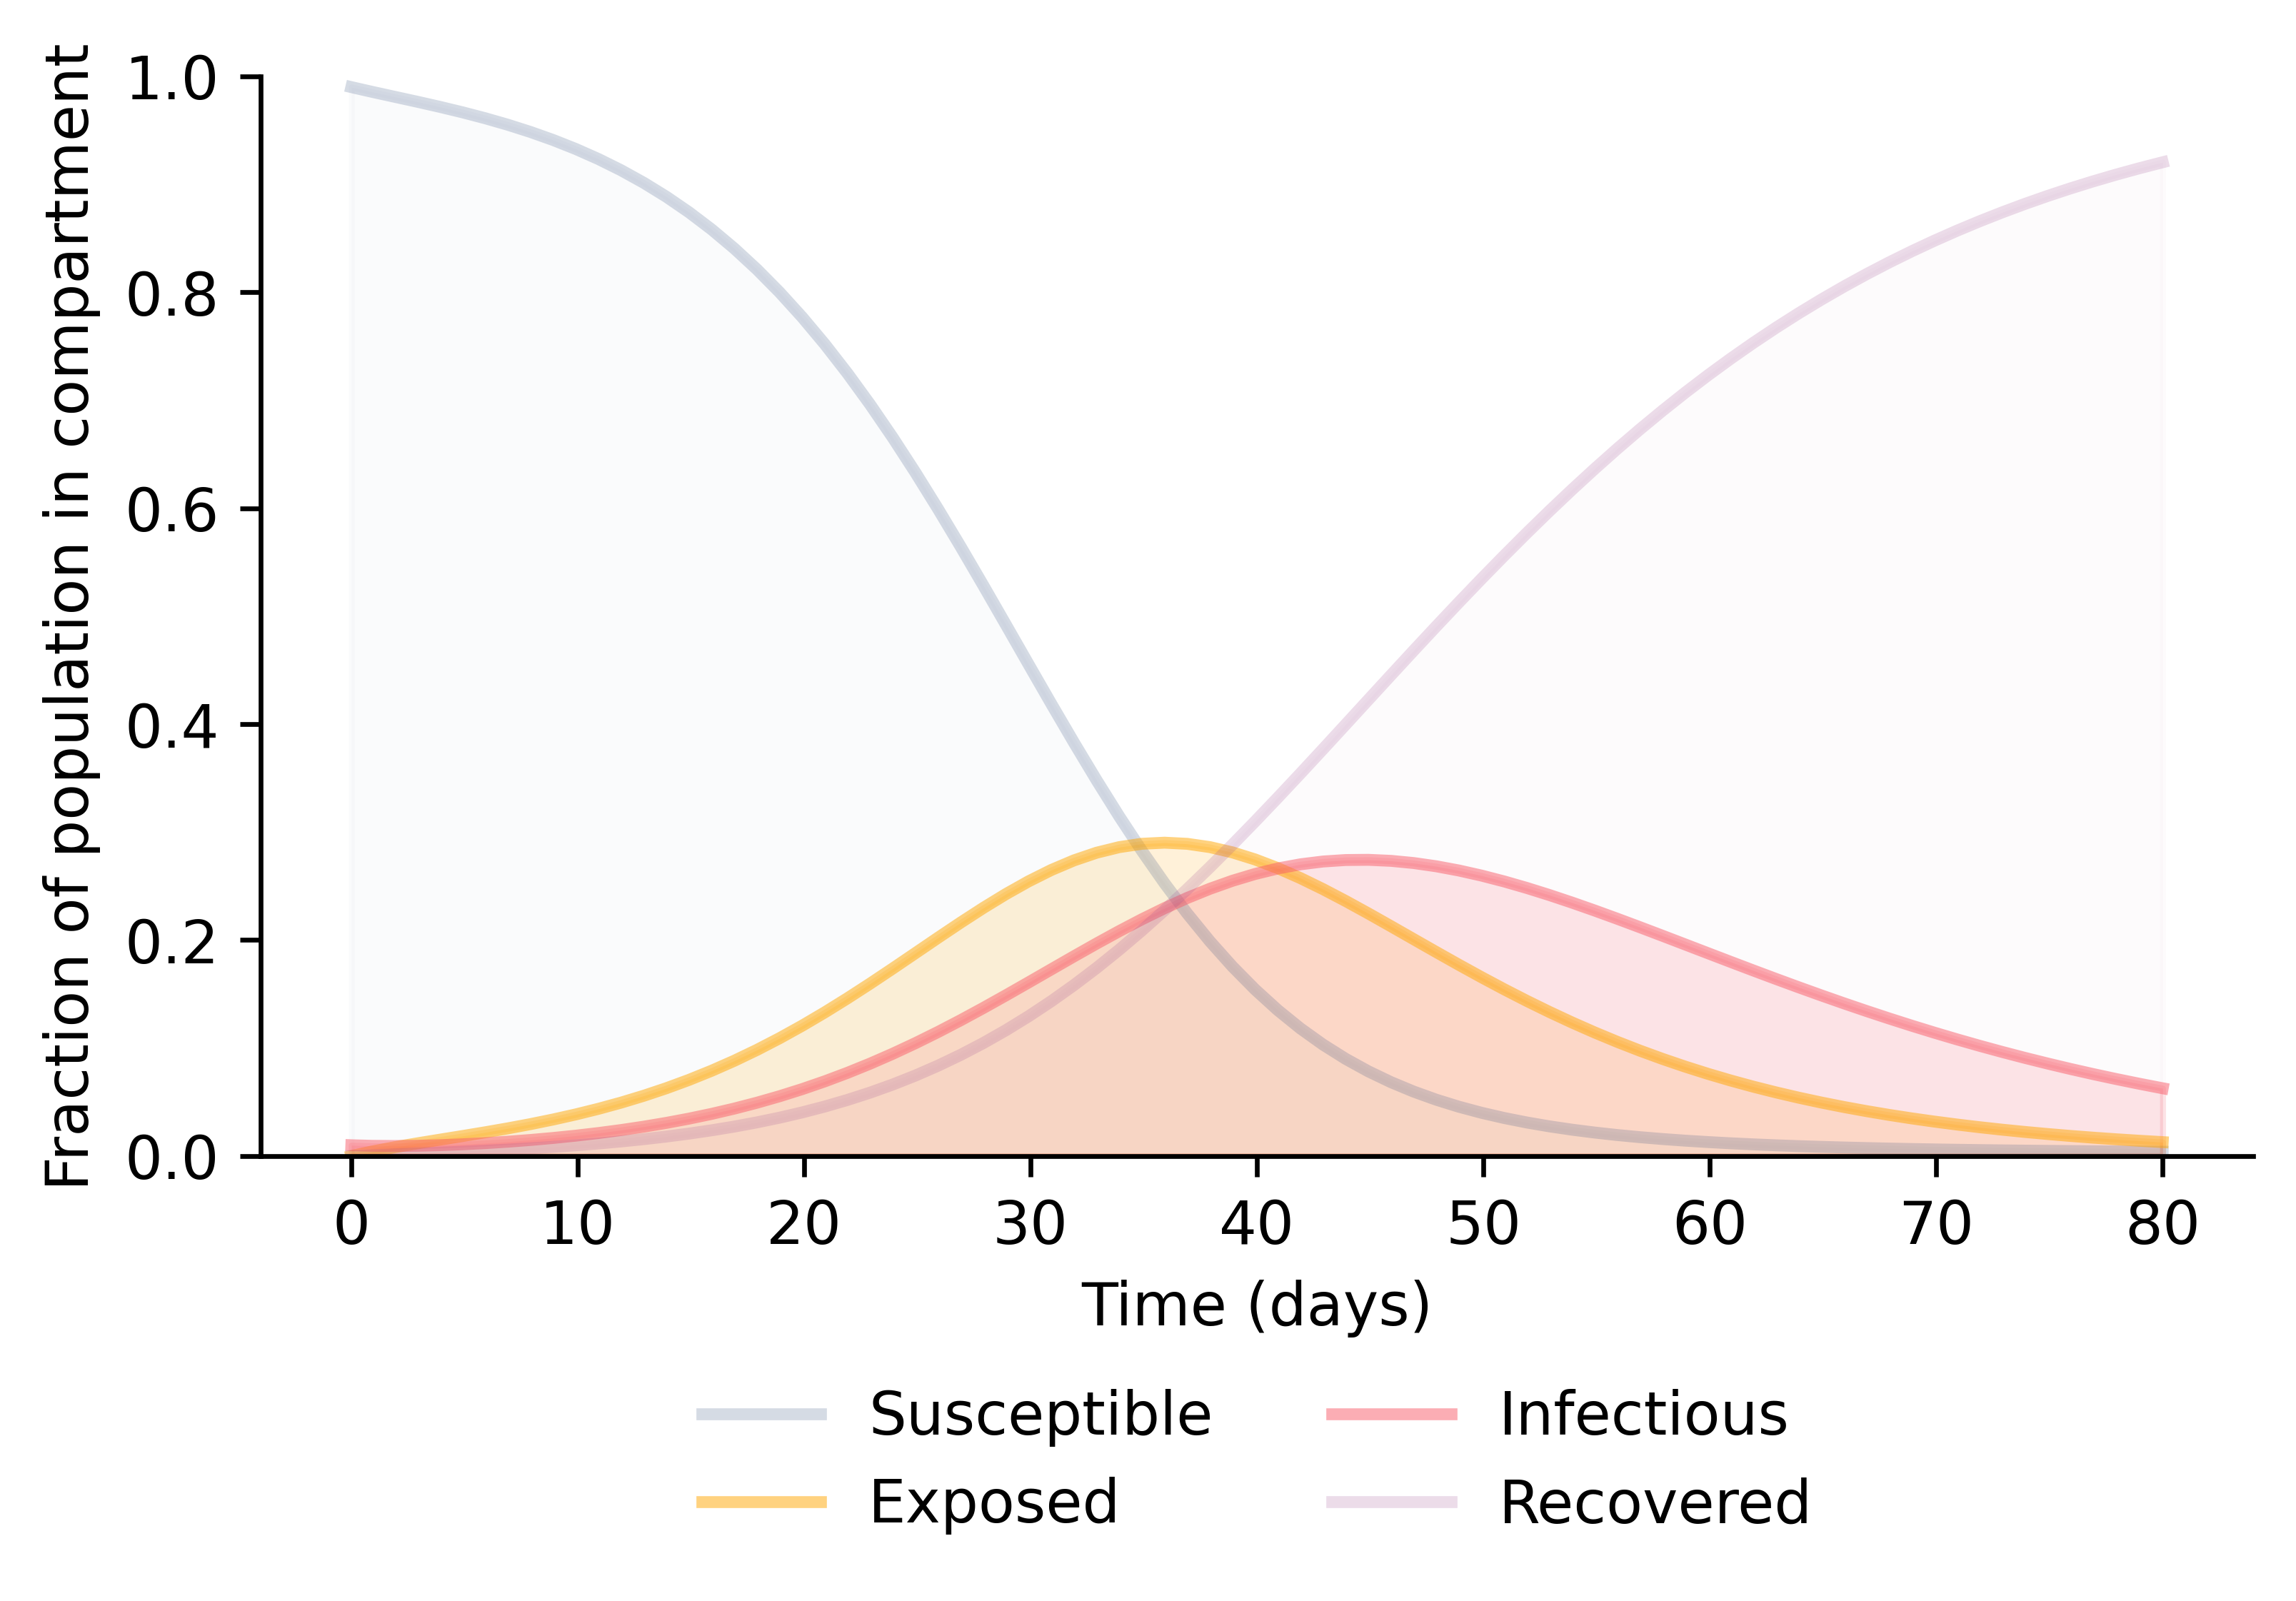

In [25]:
S, E, I, R = res.y

fig = plt.figure(facecolor="w", figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.2, lw=2, label="Susceptible")
ax.plot(res.t, E, color=COLORS["E"], alpha=0.5, lw=2, label="Exposed")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(res.t, R, color=COLORS["R"], alpha=0.2, lw=2, label="Recovered")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.02)
ax.fill_between(res.t, 0, E, color=COLORS["E"], alpha=0.15)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(res.t, 0, R, color=COLORS["R"], alpha=0.02)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.4), loc="lower center", ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("seir_integral.pdf")
plt.show()

# SIRC

\begin{equation}
    \frac{dS}{dt} = - \beta S (I + C)
\end{equation}

\begin{equation}
    \frac{dI}{dt} = \beta S (I + C) - \gamma I
\end{equation}

\begin{equation}
    \frac{dR}{dt} = (1 - \theta) \gamma I + \omega C
\end{equation}

\begin{equation}
    \frac{dC}{dt} = \theta \gamma I - \omega C
\end{equation}

In [26]:
I_0 = 1e-2
S_0 = 1 - I_0
R_0, C_0 = 0, 0

y_0 = (S_0, I_0, R_0, C_0)


R0 = 6
tau = 12
gamma = 1/tau
beta = R0 * gamma
omega = 0.005
theta = 0.25

In [27]:
def deriv(t, y, beta, gamma, omega, theta):
    S, I, R, C = y

    dSdt = - beta * S * (I + C)
    dIdt = beta * S * (I + C) - gamma * I
    dRdt = (1 - theta) * gamma * I + omega * C
    dCdt = theta * gamma * I - omega * C

    return dSdt, dIdt, dRdt, dCdt

In [28]:
res = solve_ivp(fun=deriv, t_span = (0, 80), y0=y_0, args=(beta, gamma, omega, theta), max_step=1)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_53999/3704802419.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


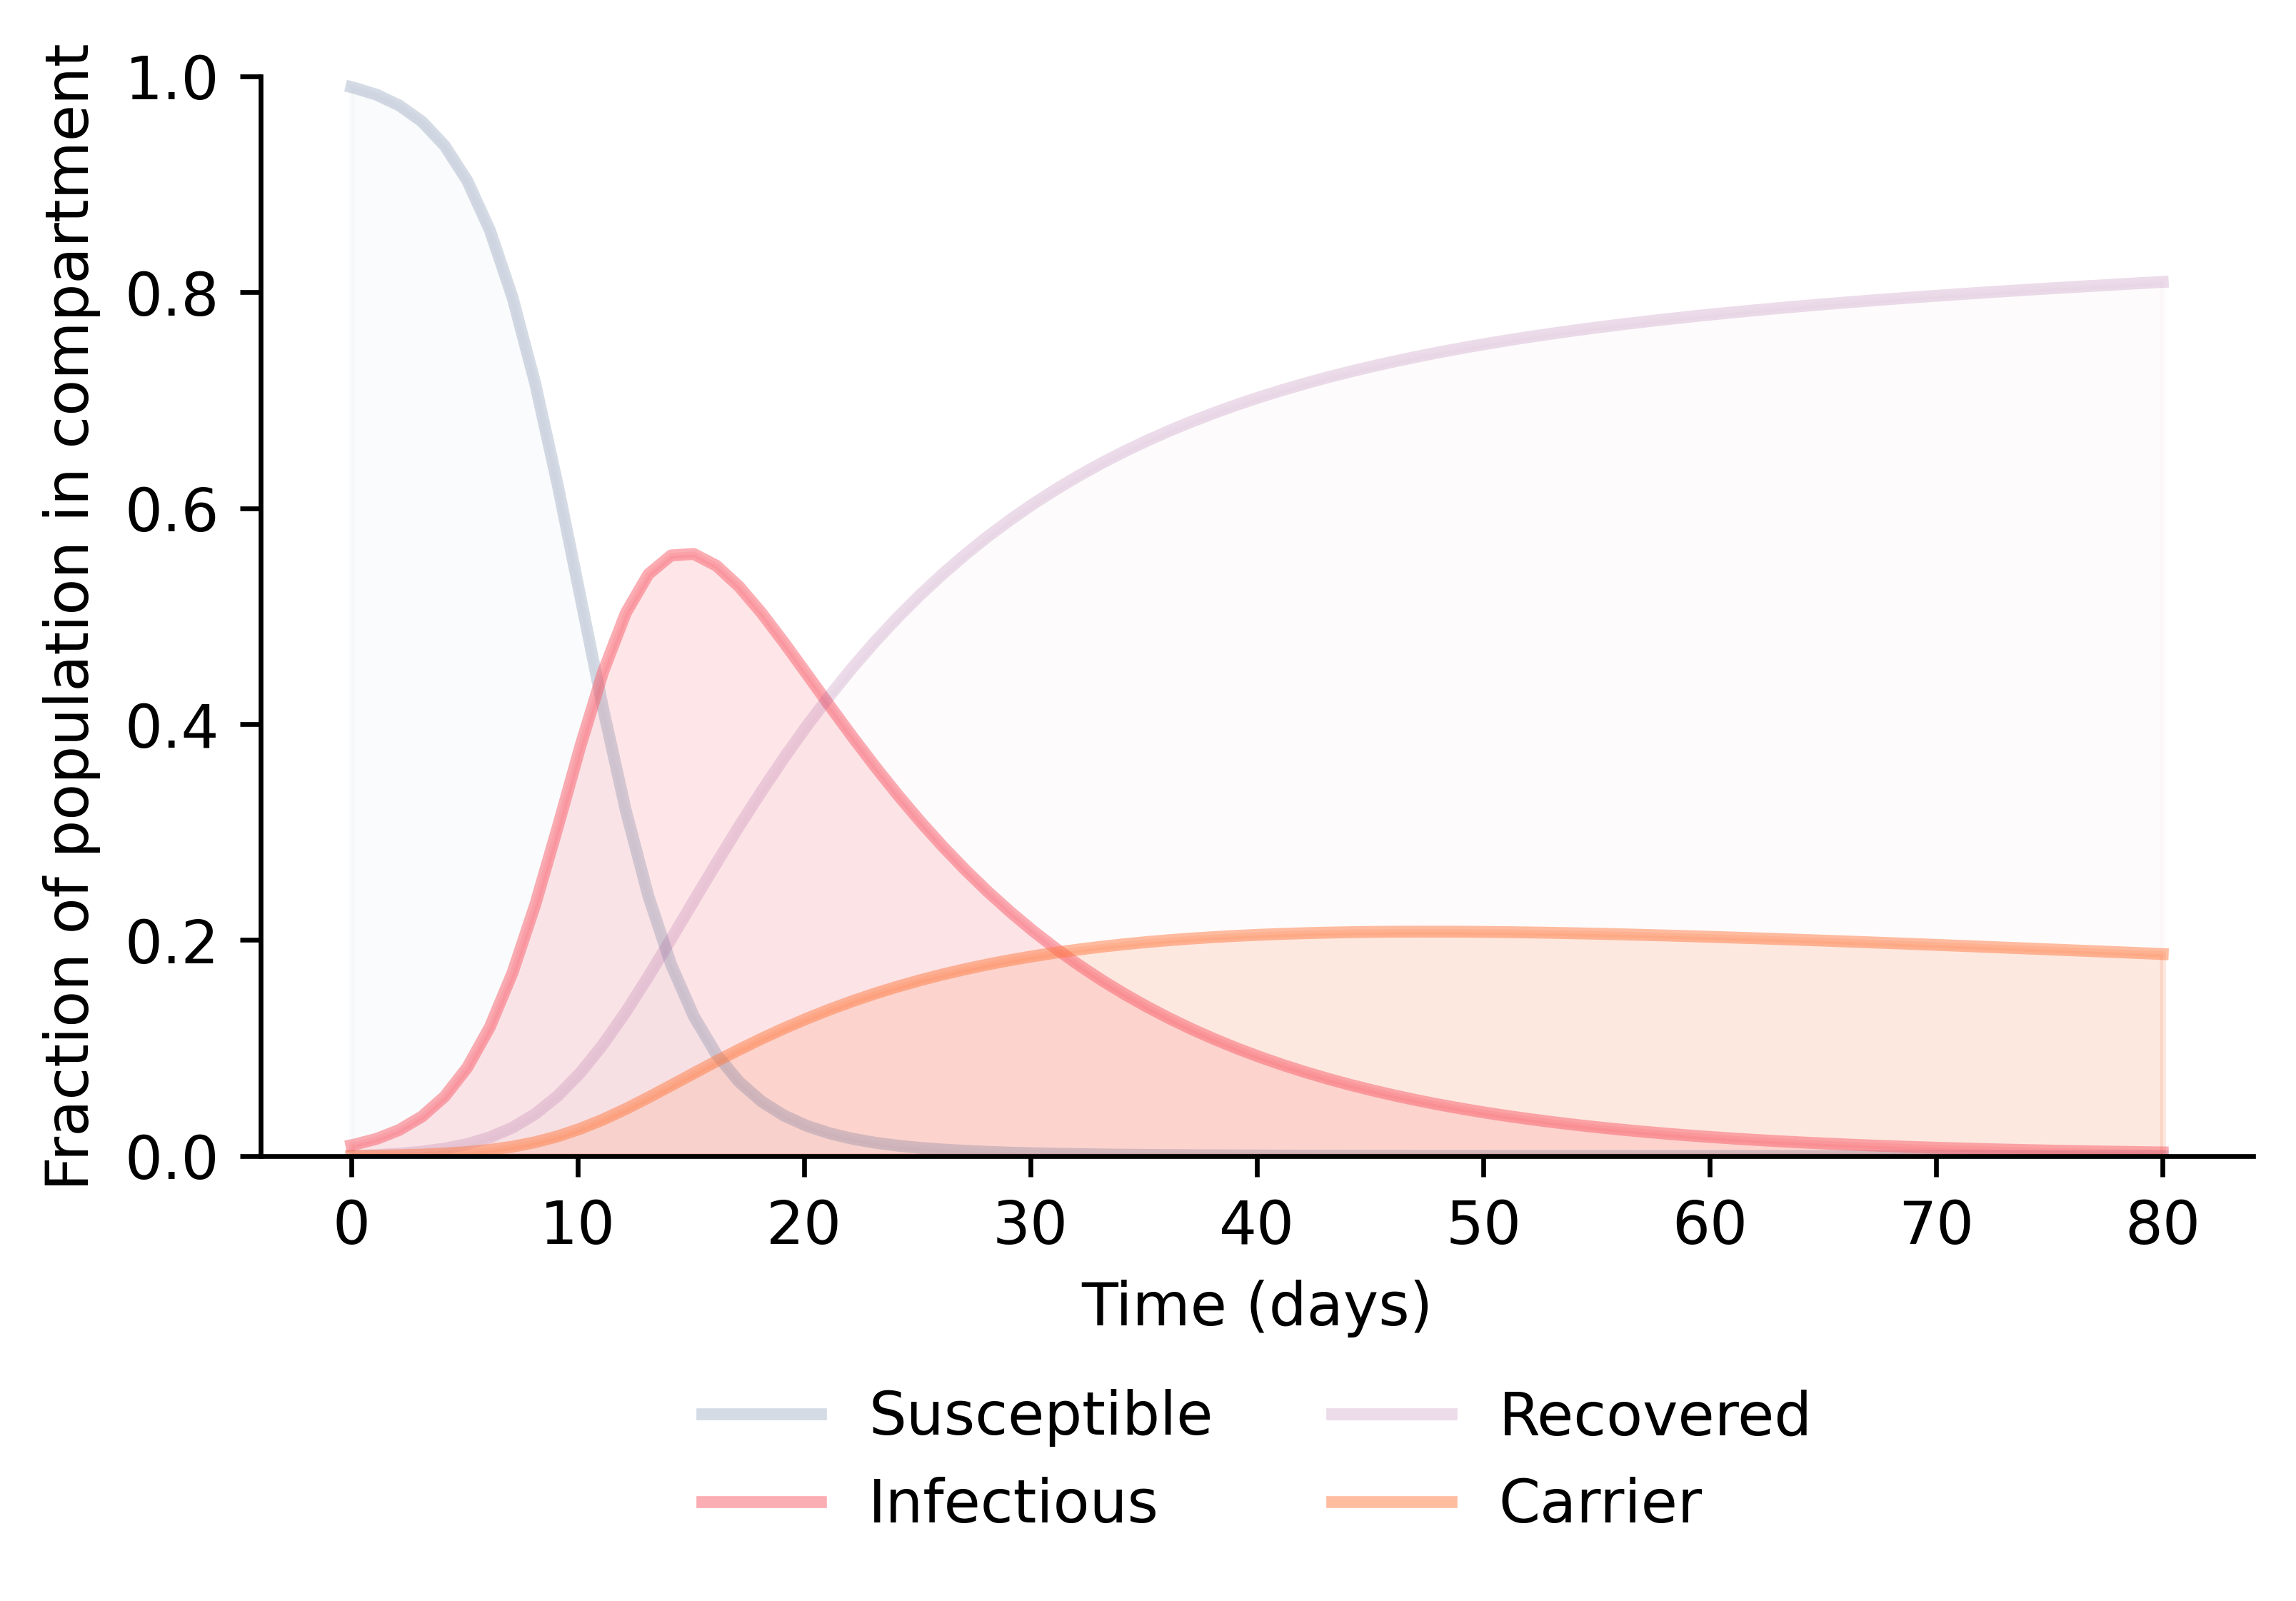

In [29]:
S, I, R, C = res.y

fig = plt.figure(facecolor="w", figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.2, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(res.t, R, color=COLORS["R"], alpha=0.2, lw=2, label="Recovered")
ax.plot(res.t, C, color=COLORS["C"], alpha=0.5, lw=2, label="Carrier")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.02)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(res.t, 0, R, color=COLORS["R"], alpha=0.02)
ax.fill_between(res.t, 0, C, color=COLORS["C"], alpha=0.15)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Fraction of population in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.4), loc="lower center", ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("sirc_integral.pdf")
plt.show()